**Description of the "Walmart Sales Forecasting" Dataset Files**

**1. features.csv**
* **Store**: Store identifier.
* **Date**: Observation date.
* **Temperature**: Average temperature of the day in the store's location.
* **FuelPrice**: Fuel price in the store's region.
* **MarkDown1**: Discount value applied to products or departments during a specific promotional period
* **MarkDown2**: Discount value applied to products or departments during another specific promotional period.
* **MarkDown3**: Discount value applied to products or departments during a third specific promotional period.
* **MarkDown4**: Discount value applied to products or departments during a fourth specific promotional period.
* **MarkDown5**: Discount value applied to products or departments during a fourth specific promotional period.
* **CPI**: Consumer Price Index (CPI).
* **Unemployment**: Unemployment rate in the region.
* **IsHoliday**: Indicates if the date is a holiday (True/False).

**2. stores.csv**
* **Store**: Unique store identifier.
* **Type**: Type of store (e.g., Supercenter, neighborhood store).
* **Size**: Store size (in square feet).

**3. test.csv**
* **Store**: Store identifier.
* **Dept**: Department identifier within the store.
* **Date**: Date for sales prediction.
* **IsHoliday**: Indicates if the date is a holiday (True/False).

**4. train.csv**
* **Store**: Store identifier.
* **Dept**: Department identifier.
* **Date**: Date of sales.
* **Weekly_Sales**: Value of weekly sales.
* **IsHoliday**: Indicates if the date corresponds to a holiday (True/False).


**Step 1  - Import the data**

In [316]:
#Impport libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
import itertools
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [317]:
#Loading the first dataset
df_features = pd.read_csv('/content/features.csv')
df_features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [318]:
#Loading the second dataset
df_stores = pd.read_csv('/content/stores.csv')
df_stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [319]:
#Loading the third dataset
df_test = pd.read_csv('/content/test.csv')
df_test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [320]:
#Loading the fourth dataset
df_train = pd.read_csv('/content/train.csv')
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


**Step 2 - Wrangle the dataset**

In [321]:
#Merging 'df_train' with 'df_features' and 'df_stores'
df = df_train.merge(df_features, on=['Store', 'Date'], how='inner').merge(df_stores, on=['Store'], how='inner')
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315


In [322]:
#Removing duplicated column
df.drop('IsHoliday_y', axis=1, inplace=True)

#Renaming the column
df.rename(columns={'IsHoliday_x': 'IsHoliday'}, inplace=True)
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


In [323]:
#Changing data to datatime
df['Date'] = pd.to_datetime(df['Date'])

In [324]:
#Creating new date columns
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Year,Month,Week
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,2010,2,5
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315,2010,2,6
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315,2010,2,7
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315,2010,2,8
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315,2010,3,9


**Step 3 - Evaluate data quality**

In [325]:
#Verify general information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
 5   Temperature   421570 non-null  float64       
 6   Fuel_Price    421570 non-null  float64       
 7   MarkDown1     150681 non-null  float64       
 8   MarkDown2     111248 non-null  float64       
 9   MarkDown3     137091 non-null  float64       
 10  MarkDown4     134967 non-null  float64       
 11  MarkDown5     151432 non-null  float64       
 12  CPI           421570 non-null  float64       
 13  Unemployment  421570 non-null  float64       
 14  Type          421570 non-null  object        
 15  Size          421

In [326]:
#Verify duplicated rows
duplicated_rows= df.duplicated().sum()
print("Duplicated rows: ",duplicated_rows)

Duplicated rows:  0


In [327]:
#Verify null values
df.isnull().sum()

,0
Store,0
Dept,0
Date,0
Weekly_Sales,0
IsHoliday,0
Temperature,0
Fuel_Price,0
MarkDown1,270889
MarkDown2,310322
MarkDown3,284479


In [328]:
#Filling null values with 0 in MarkDown columns
df.fillna(0, inplace=True)
df.isnull().sum()

,0
Store,0
Dept,0
Date,0
Weekly_Sales,0
IsHoliday,0
Temperature,0
Fuel_Price,0
MarkDown1,0
MarkDown2,0
MarkDown3,0


In [329]:
#Analyzing statistical information
df.describe()

,Store,Dept,Date,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,Year,Month,Week
count,421570.000000,421570.000000,421570,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.0
mean,22.200546,44.260317,2011-06-18 08:30:31.963375104,15981.258123,60.090059,3.361027,2590.074819,879.974298,468.087665,1083.132268,1662.772385,171.201947,7.960289,136727.915739,2010.968591,6.449510,25.826762
min,1.000000,1.000000,2010-02-05 00:00:00,-4988.940000,-2.060000,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000,34875.000000,2010.000000,1.000000,1.0
25%,11.000000,18.000000,2010-10-08 00:00:00,2079.650000,46.680000,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000,93638.000000,2010.000000,4.000000,14.0
50%,22.000000,37.000000,2011-06-17 00:00:00,7612.030000,62.090000,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.318780,7.866000,140167.000000,2011.000000,6.000000,26.0
75%,33.000000,74.000000,2012-02-24 00:00:00,20205.852500,74.280000,3.738000,2809.050000,2.200000,4.540000,425.290000,2168.040000,212.416993,8.572000,202505.000000,2012.000000,9.000000,38.0
max,45.000000,99.000000,2012-10-26 00:00:00,693099.360000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000,2012.000000,12.000000,52.0
std,12.785297,30.492054,NaN,22711.183519,18.447931,0.458515,6052.385934,5084.538801,5528.873453,3894.529945,4207.629321,39.159276,1.863296,60980.583328,0.796876,3.243217,14.151887


The initial date is February 5th, 2010, and the final date is October 26th, 2012.





**Step 4 - Working in the 'Weekly_Sales' column**

In [330]:
#Mean of weekly sales in each store and department
table_weekly_sales = pd.pivot_table(df, values='Weekly_Sales', index='Store', columns='Dept', aggfunc='mean')
table_weekly_sales

Dept,1,2,3,4,5,6,7,8,9,10,...,90,91,92,93,94,95,96,97,98,99
Store,,,,,,,,,,,,,,,,,,,,,
1,22513.322937,46102.090420,13150.478042,36964.154476,24257.941119,4801.780140,24566.487413,35718.257622,28062.052238,31033.386364,...,82427.547832,64238.943427,135458.969510,71699.182378,63180.568182,120772.062168,33251.831639,35207.348811,11827.770769,306.091081
2,30777.980769,65912.922517,17476.563357,45607.666573,30555.315315,6808.382517,40477.837063,58707.369441,34375.864476,38845.854476,...,97611.537133,80610.380350,164840.230979,70581.977063,70018.672517,143588.751888,34319.063846,40697.204056,14035.400839,475.896905
3,7328.621049,16841.775664,5509.300769,8434.186503,11695.366573,2012.411818,10044.341608,8310.254196,9062.007692,10871.944126,...,1540.049161,318.685594,7568.280210,NaN,656.294444,15745.528252,3934.540000,343.437357,30.570833,NaN
4,36979.940070,93639.315385,19012.491678,56603.400140,45668.406783,8241.777692,50728.151399,62949.723776,34437.170979,37269.667413,...,89248.965524,66535.407203,159365.107902,67815.163007,68159.106573,147236.473706,38346.573077,39339.238951,15009.249371,623.182381
5,9774.553077,12317.953287,4101.085175,9860.806783,6699.202238,1191.057622,6124.484336,13735.709441,7919.805944,9783.395385,...,3059.520000,1457.221678,7759.205594,NaN,411.431486,19340.693986,5985.671119,667.070315,29.976087,NaN
6,23867.553776,50269.437273,16806.638811,34187.366503,34465.307622,7225.566643,34526.870420,47577.719790,48271.060140,47436.477902,...,53715.366084,45270.405175,99024.796503,41359.651189,41701.693497,89208.786294,30450.542238,20637.667063,9728.100629,388.636750
7,9542.801259,22603.690769,8633.536923,14950.518601,13860.350490,6329.928811,10925.757063,13970.619371,29722.736084,21136.560280,...,13858.405874,10263.880000,26530.890559,1328.178252,699.332522,34208.097273,1123.383217,4374.927902,260.886596,15.000000
8,14789.827343,35729.821748,10683.305105,21089.309301,19838.849231,3395.425455,20268.743776,26438.524336,11792.661678,20666.433776,...,39333.566154,31530.560909,60465.630000,27515.635315,25442.578042,62951.463706,16.986667,16978.366503,6880.466434,298.153714
9,11846.558252,24969.477413,7497.356783,17165.947762,19282.746014,2806.416364,13826.694336,21424.470699,13196.569720,12810.480350,...,2981.249510,869.273287,14123.063147,21.240000,599.112568,29575.050769,3596.107762,372.655556,27.930000,NaN


* We have 45 different stores distributed between numbers 1 and 45.
* We also have 81 different departments, but they are distributed between numbers 1 and 99.
* In the table, we can see negative numbers, which is impossible when referring to weekly sales.

In [331]:
#Checking how many negative values there are in the 'Weekly_Sales' column
df[df['Weekly_Sales'] < 0]

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Year,Month,Week
846,1,6,2012-08-10,-139.65,False,85.05,3.494,11436.22,245.0,6.85,6964.26,4836.22,221.958433,6.908,A,151315,2012,8,32
2384,1,18,2012-05-04,-1.27,False,75.55,3.749,21290.13,0.0,69.89,4977.35,3261.04,221.671800,7.143,A,151315,2012,5,18
6048,1,47,2010-02-19,-863.00,False,39.93,2.514,0.00,0.0,0.00,0.00,0.00,211.289143,8.106,A,151315,2010,2,7
6049,1,47,2010-03-12,-698.00,False,57.79,2.667,0.00,0.0,0.00,0.00,0.00,211.380643,8.106,A,151315,2010,3,10
6051,1,47,2010-10-08,-58.00,False,63.93,2.633,0.00,0.0,0.00,0.00,0.00,211.746754,7.838,A,151315,2010,10,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419597,45,80,2010-02-12,-0.43,True,27.73,2.773,0.00,0.0,0.00,0.00,0.00,181.982317,8.992,B,118221,2010,2,6
419598,45,80,2010-02-19,-0.27,False,31.27,2.745,0.00,0.0,0.00,0.00,0.00,182.034782,8.992,B,118221,2010,2,7
419603,45,80,2010-04-16,-1.61,False,54.28,2.899,0.00,0.0,0.00,0.00,0.00,181.692477,8.899,B,118221,2010,4,15
419614,45,80,2010-07-02,-0.27,False,76.61,2.815,0.00,0.0,0.00,0.00,0.00,182.318780,8.743,B,118221,2010,7,26


In [332]:
#Checking the percentage of negative values in the dataset
df[df['Weekly_Sales'] < 0].shape[0] / df.shape[0]
print("Percentage of negative values: ",df[df['Weekly_Sales'] < 0].shape[0] / df.shape[0]*100,"%")

Percentage of negative values:  0.30481296107408024 %


As I have only 0.3% of negative values in 'Weekly_Sales', I'll drop these negative values because I believe dropping them won't compromise the dataset.

In [333]:
#Dropping the negative values in the 'Weekly_Sales'
df.drop(df[df['Weekly_Sales'] < 0].index, inplace=True)

In [334]:
#Shape of the new dataset without negative values in the 'Weekly_Sales'
df.shape

(420285, 19)

**Step 5 - General Exploratory Data Analysis**

In [335]:
#Number of different stores
df['Store'].nunique()
print("Number of different stores: ",df['Store'].nunique())

Number of different stores:  45


In [336]:
#Number of different departments
df['Dept'].nunique()
print("Number of different departments: ",df['Dept'].nunique())

Number of different departments:  81


In [337]:
#To view the first 5 and last 5 dates
pd.concat([df['Date'].head(), df['Date'].tail()])

,Date
0,2010-02-05
1,2010-02-12
2,2010-02-19
3,2010-02-26
4,2010-03-05
421565,2012-09-28
421566,2012-10-05
421567,2012-10-12
421568,2012-10-19
421569,2012-10-26


In [338]:
#Counting how many weeks we have in holiday weeks and weekdays
df_holiday = df[df['IsHoliday'] == True]
df_non_holiday = df[df['IsHoliday'] == False]
print("Number of weeks in holiday: ",df_holiday['Date'].nunique())
print("Number of weeks in non-holiday: ",df_non_holiday['Date'].nunique())

Number of weeks in holiday:  10
Number of weeks in non-holiday:  133


In [339]:
#Analyzing the 'Weekly_Sales' volume on holidays and weekdays
total_sales_holiday = df_holiday['Weekly_Sales'].sum()
total_sales_non_holiday = df_non_holiday['Weekly_Sales'].sum()
print ("Total sales in holiday weeks: ",total_sales_holiday)
print ("Total sales in non-holiday weeks: ",total_sales_non_holiday)

Total sales in holiday weeks:  505307535.15
Total sales in non-holiday weeks:  6231999613.519998


In [340]:
#Calculating the average sales in holiday weeks and non-holiday weeks
mean_sales_holiday = total_sales_holiday / df_holiday['Date'].nunique()
mean_sales_non_holiday = total_sales_non_holiday / df_non_holiday['Date'].nunique()
print("Mean of sales in holiday weeks: ",mean_sales_holiday)
print("Mean of sales in non-holiday weeks: ",mean_sales_non_holiday)

Mean of sales in holiday weeks:  50530753.515
Mean of sales in non-holiday weeks:  46857139.95127818


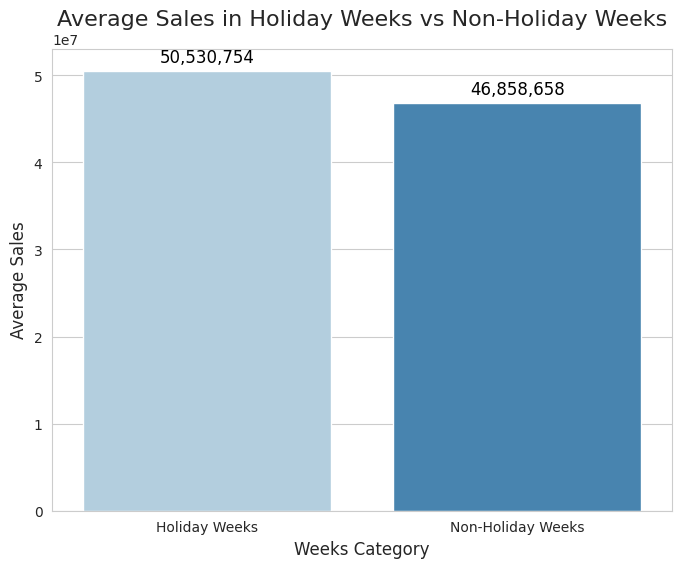

In [341]:
#Graph analysis of average sales in holiday weeks and non-holiday weeks
categories = ['Holiday Weeks', 'Non-Holiday Weeks']
values = [50530753.515, 46858658.016]
plt.figure(figsize=(8, 6))
sns.barplot(x=categories, y=values, palette='Blues')
plt.title('Average Sales in Holiday Weeks vs Non-Holiday Weeks', fontsize=16)
plt.xlabel('Weeks Category', fontsize=12)
plt.ylabel('Average Sales', fontsize=12)
for i, value in enumerate(values):
    plt.text(i, value + 1000000, f'{value:,.0f}', ha='center', fontsize=12, color='black')
plt.show()


The average sales is 7.84% higher in holidays weeks than in non-holiday weeks

In [342]:
#Analyzing the average sales volume of the best years
df.groupby('Year')['Weekly_Sales'].mean()

,Weekly_Sales
Year,
2010,16315.740243
2011,16004.658586
2012,15746.033424


In [343]:
#Analyzing the average sales volume of the best months
df.groupby('Month')['Weekly_Sales'].mean()

,Weekly_Sales
Month,
1,14177.402925
2,16044.626423
3,15462.397412
4,15693.388747
5,15843.753725
6,16394.151442
7,15903.137562
8,16109.142779
9,15145.234221


In [344]:
#Analyzing the average sales volume of the best weeks
df.groupby('Week')['Weekly_Sales'].mean()

,Weekly_Sales
Week,
1,14928.038770
2,14090.537483
3,14123.750534
4,13564.804244
5,16069.522016
6,16416.927383
7,16512.387533
8,15172.655584
9,15867.717934


**Step 6 - Holiday Bias Data Analysis**

In [345]:
#Identifying the holiday dates
df_holiday = df[df['IsHoliday'] == True]
df_holiday['Date'].unique()

<DatetimeArray>
['2010-02-12 00:00:00', '2010-09-10 00:00:00', '2010-11-26 00:00:00',
 '2010-12-31 00:00:00', '2011-02-11 00:00:00', '2011-09-09 00:00:00',
 '2011-11-25 00:00:00', '2011-12-30 00:00:00', '2012-02-10 00:00:00',
 '2012-09-07 00:00:00']
Length: 10, dtype: datetime64[ns]

2010-02-12 — Super Bowl

2010-09-10 — Labor Day

2010-11-26 — Thanksgiving Day

2010-12-31 — New Year's Eve

2011-02-11 — Super Bowl

2011-09-09 — Labor Day

2011-11-25 — Thanksgiving Day

2011-12-30 — New Year's Eve

2012-02-10 — Super Bowl

2012-09-07 — Labor Day

In [346]:
#Identifying Super Bowl and non-Super Bowl dates in the dataset
df.loc[(df['Date'] == '2010-02-12') | (df['Date'] == '2011-02-11') | (df['Date'] == '2012-02-10'), 'Super_Bowl'] = True
df.loc[(df['Date'] != '2010-02-12') & (df['Date'] != '2011-02-11') & (df['Date'] != '2012-02-10'), 'Super_Bowl'] = False

In [347]:
#Average sales on Super Bowl and non-Super Bowl holidays
mean_super_bowl = df[df['Super_Bowl'] == True]['Weekly_Sales'].mean()
mean_non_super_bowl = df[df['Super_Bowl'] == False]['Weekly_Sales'].mean()
print("Average sales in Super Bowl: ", mean_super_bowl)
print("Average sales in non-Super Bowl: ", mean_non_super_bowl)

Average sales in Super Bowl:  16416.927383367143
Average sales in non-Super Bowl:  16021.99098971588


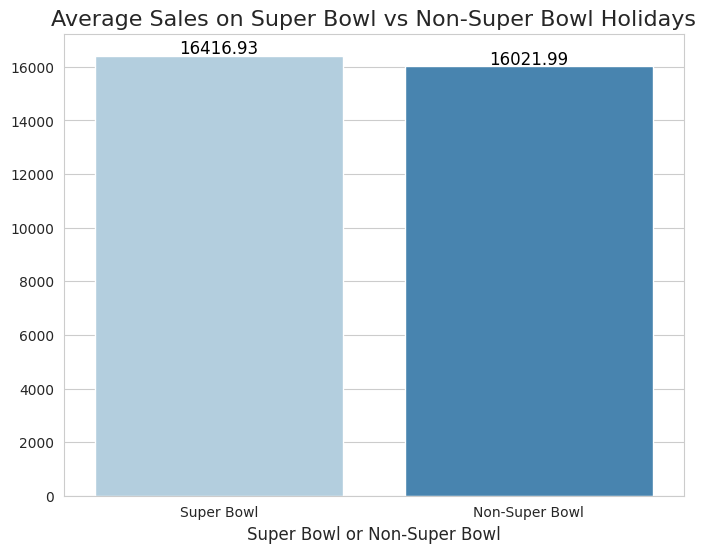

In [348]:
#Graph analysis of average sales on Super Bowl and non-Super Bowl holidays
labels = ['Super Bowl', 'Non-Super Bowl']
values = [mean_super_bowl, mean_non_super_bowl]
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=labels, y=values, palette='Blues')
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=12, color='black',
                xytext=(0, 5),
                textcoords='offset points')
plt.title('Average Sales on Super Bowl vs Non-Super Bowl Holidays', fontsize=16)
plt.xlabel('Super Bowl or Non-Super Bowl', fontsize=12)
plt.show()

The average sales are 2.46% higher on Super Bowl than on non-Super Bowl holidays.

In [349]:
#Identifying Labor Day and non-Labor Day dates in the dataset
df.loc[(df['Date'] == '2010-09-10') | (df['Date'] == '2011-09-09') | (df['Date'] == '2012-09-07'), 'Labor_Day'] = True
df.loc[(df['Date'] != '2010-09-10') & (df['Date'] != '2011-09-09') & (df['Date'] != '2012-09-07'), 'Labor_Day'] = False

In [350]:
#Average sales on Labor Day and non-Labor Day holidays
mean_labor_day = df[df['Labor_Day'] == True]['Weekly_Sales'].mean()
mean_non_labor_day = df[df['Labor_Day'] == False]['Weekly_Sales'].mean()
print("Average sales in Labor Day: ", mean_labor_day)
print("Average sales in non-Labor Day: ", mean_non_labor_day)

Average sales in Labor Day:  15932.25722970678
Average sales in non-Labor Day:  16032.435182135458


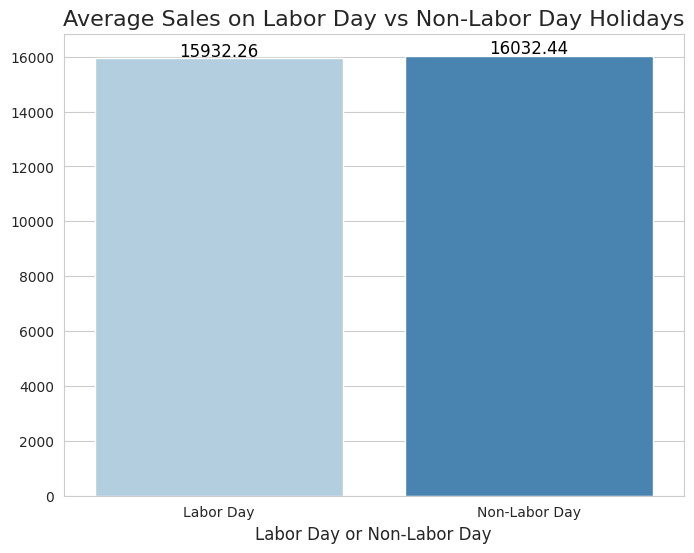

In [351]:
#Graph analysis of average sales on Labor Day and non-Labor Day holidays
labels = ['Labor Day', 'Non-Labor Day']
values = [mean_labor_day, mean_non_labor_day]
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=labels, y=values, palette='Blues')
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=12, color='black',
                xytext=(0, 5),
                textcoords='offset points')
plt.title('Average Sales on Labor Day vs Non-Labor Day Holidays', fontsize=16)
plt.xlabel('Labor Day or Non-Labor Day', fontsize=12)
plt.show()

The average sales are 0.62% lower on Labor Day than on non-Labor Day holidays.

In [352]:
#Identifying Thanksgiving Day and non-Thanksgiving Day dates in the dataset
df.loc[(df['Date'] == '2010-11-26') | (df['Date'] == '2011-11-25'), 'Thanksgiving_Day'] = True
df.loc[(df['Date'] != '2010-11-26') & (df['Date'] != '2011-11-25'), 'Thanksgiving_Day'] = False

In [353]:
#Average sales on Thanksgiving Day and non-Thanksgiving Day holidays
mean_thanksgiving_day = df[df['Thanksgiving_Day'] == True]['Weekly_Sales'].mean()
mean_non_thanksgiving_day = df[df['Thanksgiving_Day'] == False]['Weekly_Sales'].mean()
print("Average sales in Thanksgiving Day: ", mean_thanksgiving_day)
print("Average sales in non-Thanksgiving Day: ", mean_non_thanksgiving_day)

Average sales in Thanksgiving Day:  22269.601767574844
Average sales in non-Thanksgiving Day:  15940.792675948918


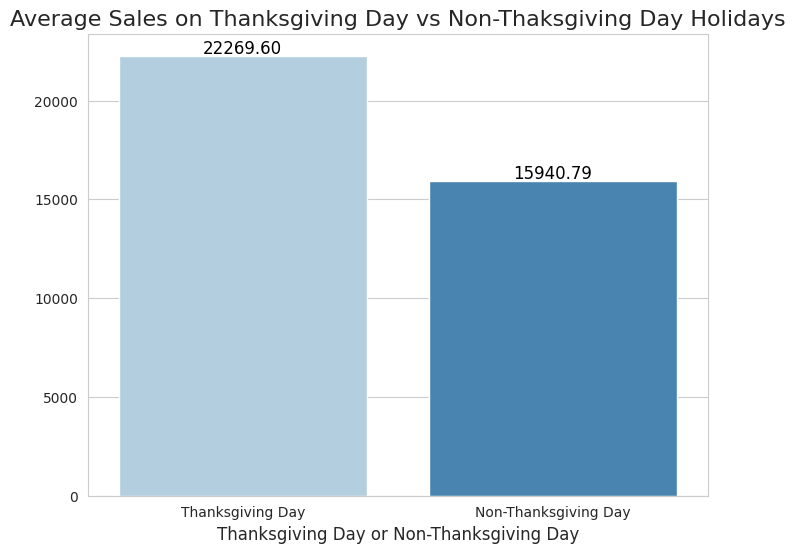

In [354]:
#Graph analysis of average sales on Thanksgiving Day and non-Thanksgiving Day holidays
labels = ['Thanksgiving Day', 'Non-Thanksgiving Day']
values = [mean_thanksgiving_day, mean_non_thanksgiving_day]
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=labels, y=values, palette='Blues')
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=12, color='black',
                xytext=(0, 5),
                textcoords='offset points')
plt.title('Average Sales on Thanksgiving Day vs Non-Thaksgiving Day Holidays', fontsize=16)
plt.xlabel('Thanksgiving Day or Non-Thanksgiving Day', fontsize=12)
plt.show()

The average sales are 39.70% higher on Thanksgiving Day than on Non-Thanksgiving Day holidays.

In [355]:
#Identifying New Year's Eve and non-New Year's Eve dates in the dataset
df.loc[(df['Date'] == '2010-12-31') | (df['Date'] == '2011-12-30'), 'New_Years_Eve'] = True
df.loc[(df['Date'] != '2010-12-31') & (df['Date'] != '2011-12-30'), 'New_Years_Eve'] = False

In [356]:
#Average sales on New Year's Eve and non-New Year's Eve holidays
mean_new_years_eve = df[df['New_Years_Eve'] == True]['Weekly_Sales'].mean()
mean_non_new_years_eve = df[df['New_Years_Eve'] == False]['Weekly_Sales'].mean()
print("Average sales in New Year's Eve: ", mean_new_years_eve)
print("Average sales in non-New Year's Eve: ", mean_non_new_years_eve)

Average sales in New Year's Eve:  14632.663507614212
Average sales in non-New Year's Eve:  16050.263909116136


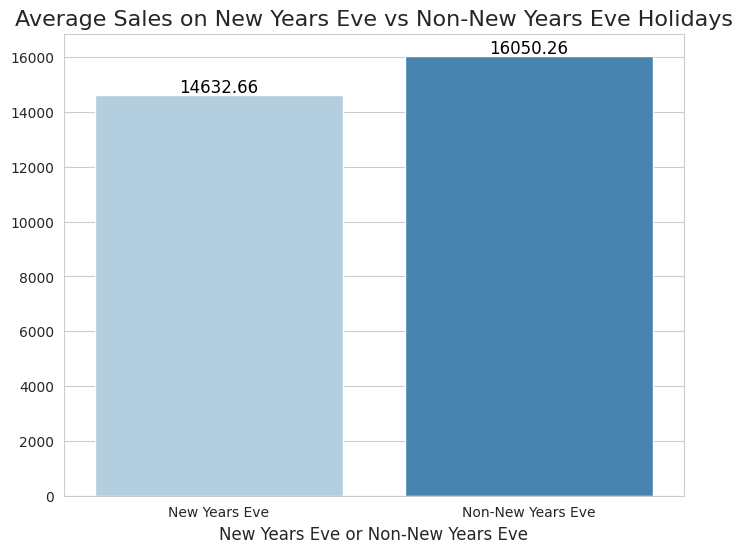

In [357]:
#Graph analysis of average sales on New Year's Eve and non-New Year's Eve holidays
labels = ['New Years Eve', 'Non-New Years Eve']
values = [mean_new_years_eve, mean_non_new_years_eve]
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=labels, y=values, palette='Blues')
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=12, color='black',
                xytext=(0, 5),
                textcoords='offset points')
plt.title('Average Sales on New Years Eve vs Non-New Years Eve Holidays', fontsize=16)
plt.xlabel('New Years Eve or Non-New Years Eve', fontsize=12)
plt.show()

The average sales are 9.69% lower on New Year's Eve than on Non-New Year's Eve holidays.



Analyzing the graphs, we can conclude that the highest average sales are on Thanksgiving holidays, with 39.70% higher sales, followed by Super Bowl holidays, which have only 2.46% higher sales. On the other hand, Labor Day and New Year's Eve holidays have 0.62% and 9.69% lower sales, respectively.

In [358]:
#Analyzing the Weekly Sales by type of store on Super Bowl and non-Super Bowl holidays
df.groupby(['Super_Bowl', 'Type'])['Weekly_Sales'].mean()

Super_Bowl  Type
False       A       20134.993683
            B       12284.349447
            C        9534.047011
True        A       20612.757674
            B       12463.412421
            C       10179.271884
Name: Weekly_Sales, dtype: float64

In [359]:
#Analyzing the Weekly Sales by type of store on Labor Day and non-Labor Day holidays
df.groupby(['Labor_Day', 'Type'])['Weekly_Sales'].mean()

Labor_Day  Type
False      A       20148.146905
           B       12292.563234
           C        9540.033102
True       A       20004.267422
           B       12080.755653
           C        9893.459258
Name: Weekly_Sales, dtype: float64

In [360]:
#Analyzing the Weekly Sales by type of store on Thansksgiving Day and non-Thaksgiving Day holidays
df.groupby(['Thanksgiving_Day', 'Type'])['Weekly_Sales'].mean()

Thanksgiving_Day  Type
False             A       20040.981576
                  B       12195.285567
                  C        9545.326177
True              A       27397.776346
                  B       18733.973971
                  C        9696.566616
Name: Weekly_Sales, dtype: float64

In [361]:
#Analyzing the Weekly Sales by type of store on New Year's Eve and non-New Year's Eve holidays
df.groupby(['New_Years_Eve', 'Type'])['Weekly_Sales'].mean()

New_Years_Eve  Type
False          A       20171.304550
               B       12299.610446
               C        9568.895179
True           A       18310.167535
               B       11483.973221
               C        8031.520607
Name: Weekly_Sales, dtype: float64

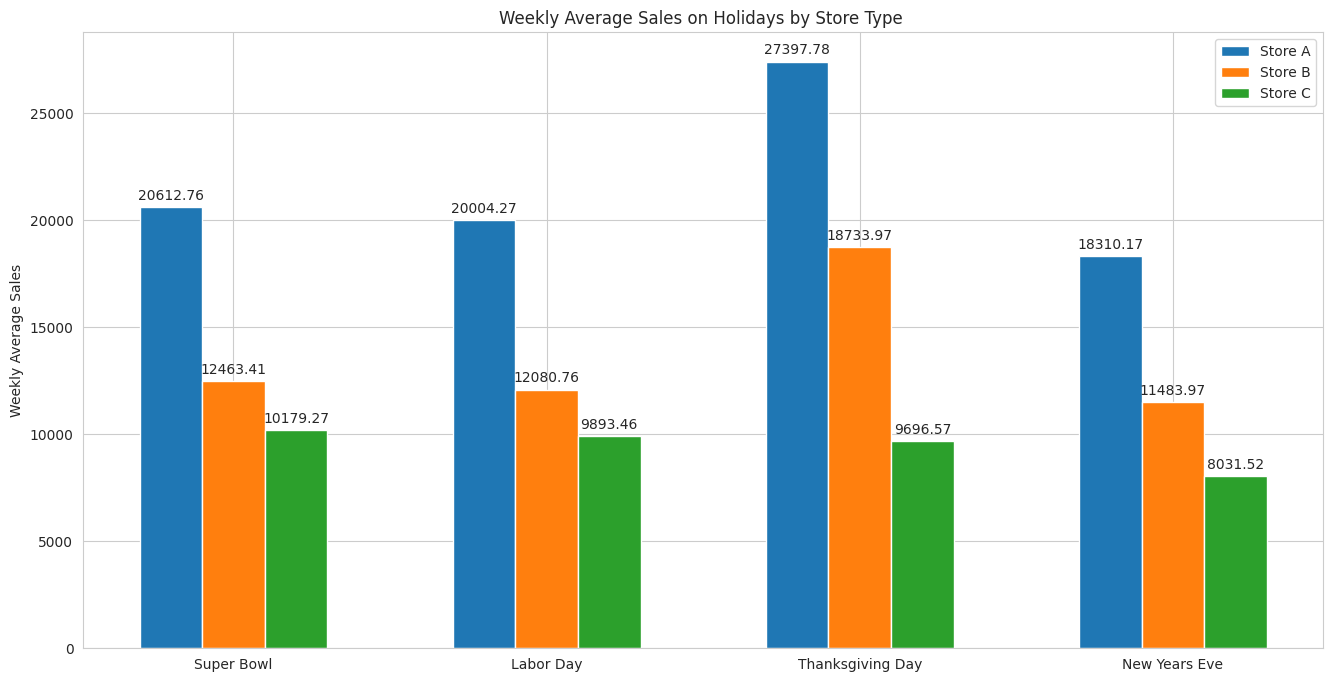

In [362]:
#Analyzing the sales average by store type

sns.set_style("whitegrid")

labels = ['Super Bowl', 'Labor Day', 'Thanksgiving Day', 'New Years Eve']

store_A = [20612.757674, 20004.267422, 27397.776346, 18310.167535]
store_B = [12463.412421, 12080.755653, 18733.973971, 11483.973221]
store_C = [10179.271884, 9893.459258, 9696.566616, 8031.520607]

fig, ax = plt.subplots(figsize=(16, 8))

# Define x and width
x = np.arange(len(labels))
width = 0.2

# Plotting bars for each store type
rects1 = ax.bar(x - width, store_A, width, label='Store A')
rects2 = ax.bar(x , store_B, width, label='Store B')
rects3 = ax.bar(x + width, store_C, width, label='Store C')

# Setting labels and titles
ax.set_ylabel('Weekly Average Sales')
ax.set_title('Weekly Average Sales on Holidays by Store Type ')
ax.set_xticks(x)  #Setting the x-axis tick locations
ax.set_xticklabels(labels)  #Setting the x-axis tick labels
ax.legend()

# Function to add labels on top of bars
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),  #Formatting the height value
                    xy=(rect.get_x() + rect.get_width() / 2, height),  # Positioning
                    xytext=(0, 3),  #Offset for better readability
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.show()

We can conclude that the average sales are always highest at Store A and lowest at Store C on any holiday.

**Step 7 - Analyzing the Relationship Between Size and Type**

In [363]:
#Statistical analysis
df_store= df.groupby('Type').describe()['Size']
df_store

,count,mean,min,25%,50%,75%,max,std
Type,,,,,,,,
A,214993.0,182226.385180,39690.0,158114.0,202505.0,203819.0,219622.0,41531.707127
B,162819.0,101798.351433,34875.0,93188.0,114533.0,123737.0,140167.0,30943.463950
C,42473.0,40536.097521,39690.0,39690.0,39910.0,41062.0,42988.0,1194.667341


Text(0.5, 0, 'Type of Store')

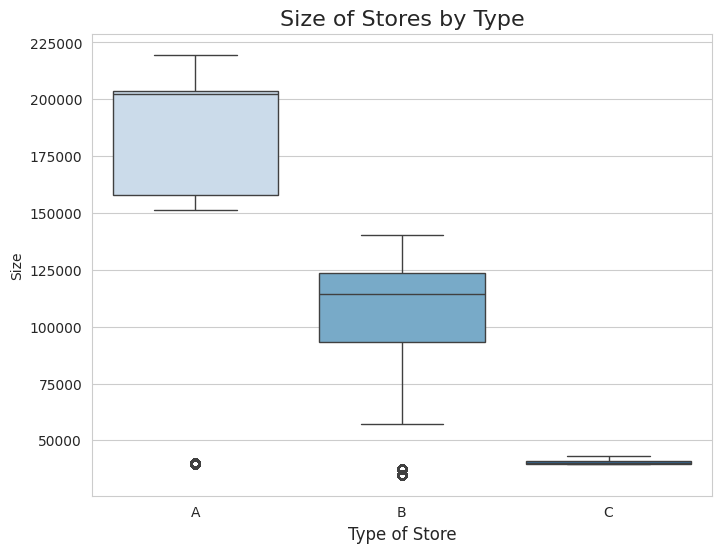

In [364]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Type', y='Size', data=df, palette='Blues')
plt.title('Size of Stores by Type', fontsize=16)
plt.xlabel('Type of Store', fontsize=12)

We can conclude that volume sales have a relationship with store size. For example, the highest average sales are at Store A, which is the largest store, whereas the lowest average sales are at Store C, which is the smallest store.

**Step 8 - Analyzing Sales**

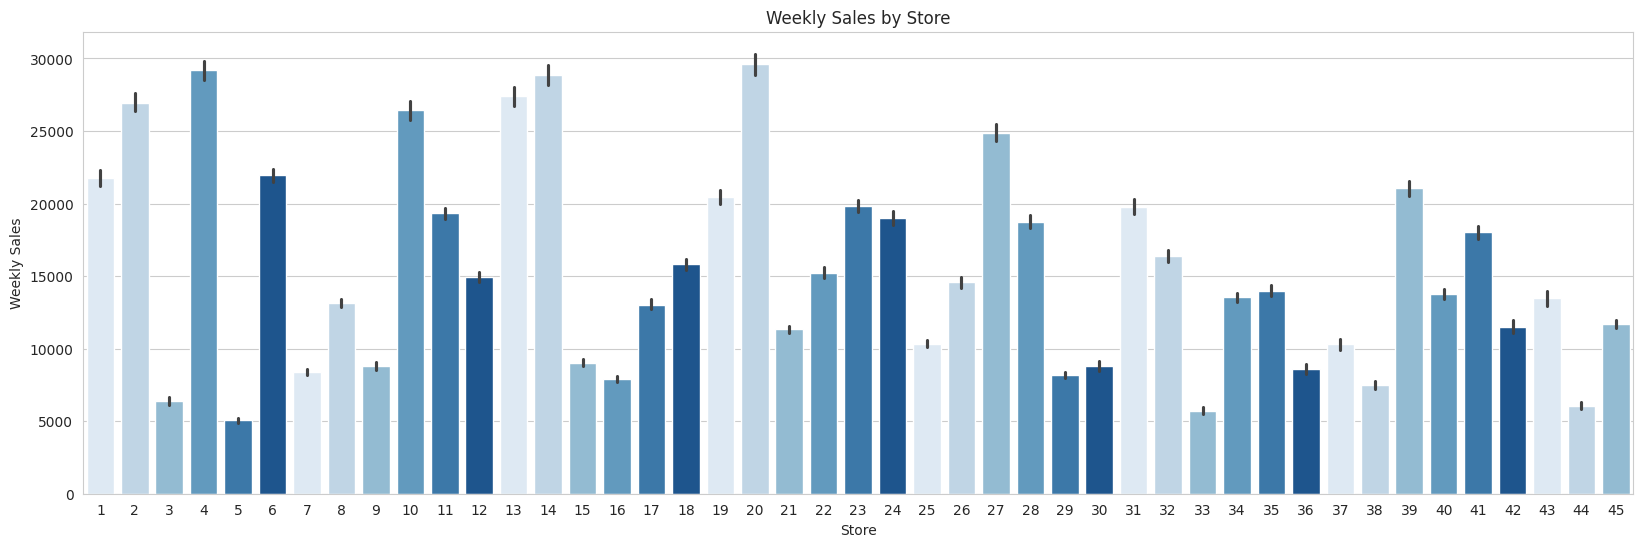

In [365]:
#Analyzing the average weekly sales by store
plt.figure(figsize=(20,6))
fig = sns.barplot(x='Store', y='Weekly_Sales', data=df,
                  palette=sns.color_palette("Blues"))
plt.title('Weekly Sales by Store')
plt.xlabel('Store')
plt.ylabel('Weekly Sales')
plt.show()

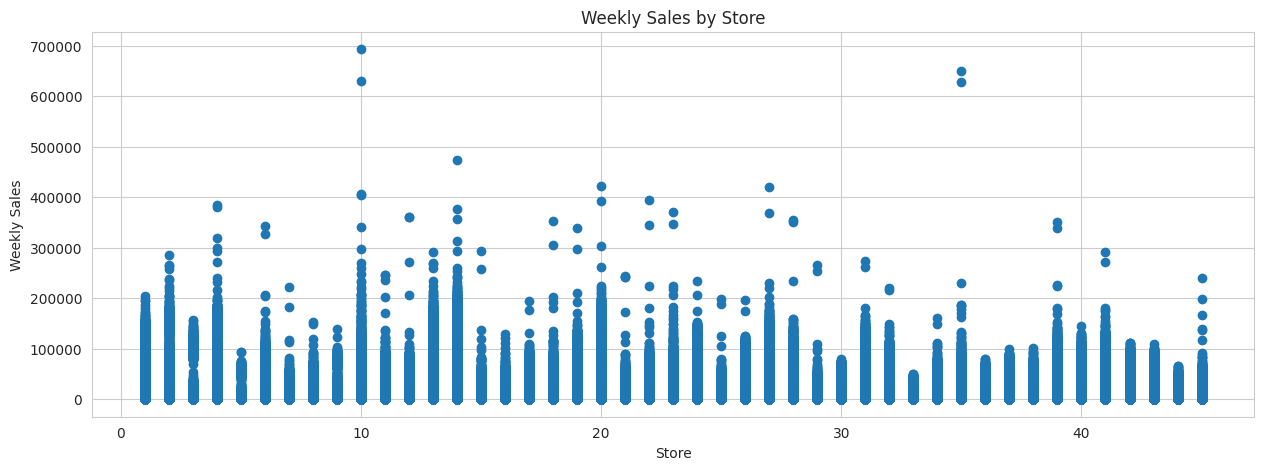

In [366]:
#Analyzing sales behavior by store
x = df['Store']
y = df['Weekly_Sales']
plt.figure(figsize=(15,5))
plt.title('Weekly Sales by Store')
plt.xlabel('Store')
plt.ylabel('Weekly Sales')
plt.scatter(x,y)
plt.show()

We can conclude that the highest average weekly sales were at Store 20, but the highest sales volume in a specific week was at Store 10.

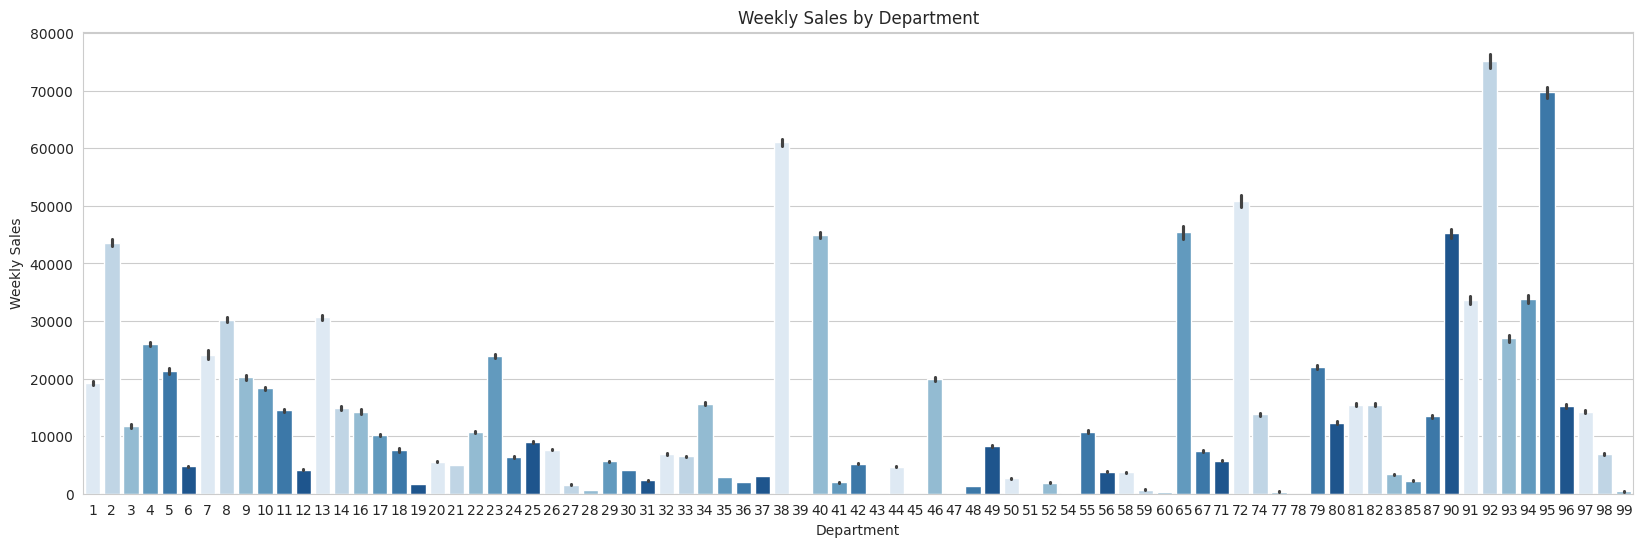

In [367]:
#Analyzing the average weekly sales by department
plt.figure(figsize=(20,6))
fig = sns.barplot(x='Dept', y='Weekly_Sales', data=df,
                  palette=sns.color_palette("Blues"))
plt.title('Weekly Sales by Department')
plt.xlabel('Department')
plt.ylabel('Weekly Sales')
plt.show()

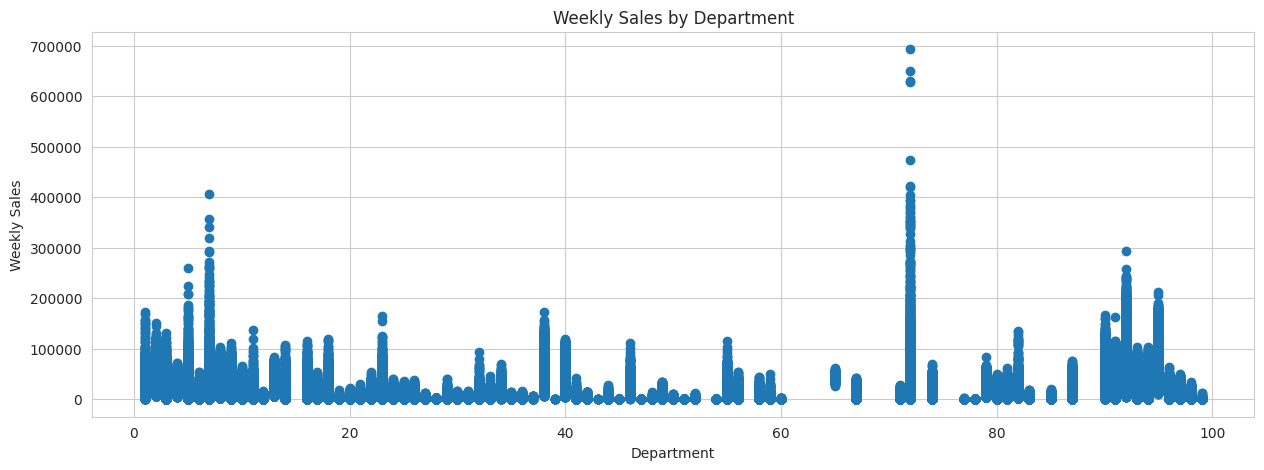

In [368]:
#Analyzing sales behavior by department
x = df['Dept']
y = df['Weekly_Sales']
plt.figure(figsize=(15,5))
plt.title('Weekly Sales by Department')
plt.xlabel('Department')
plt.ylabel('Weekly Sales')
plt.scatter(x,y)
plt.show()

The same behavior happens when we're analyzing the sales volume by department. The highest average sales were at Department 92, but the highest sales volume was at a department between 60 and 80.

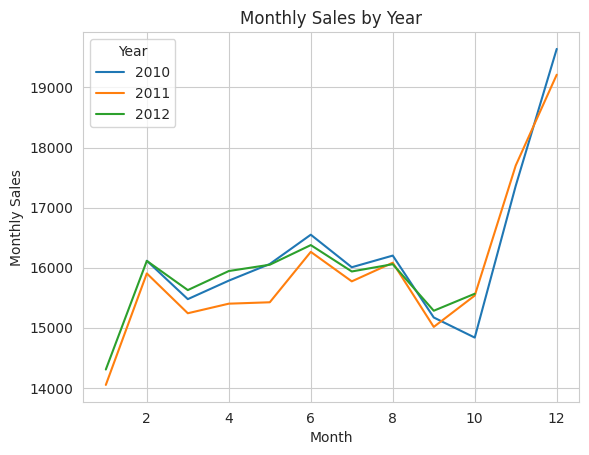

In [369]:
#Plotting monthly sales by year
monthly_sales_by_year = pd.pivot_table(df, values = "Weekly_Sales", columns = "Year", index = "Month")
monthly_sales_by_year.plot()
plt.title('Monthly Sales by Year')
plt.xlabel('Month')
plt.ylabel('Monthly Sales')
plt.show()

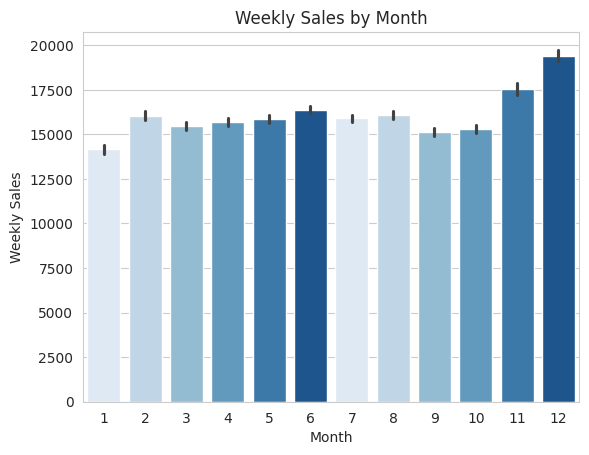

In [370]:
#Plotting monthly sales by month
monthly_sales= sns.barplot(x='Month', y='Weekly_Sales', data=df,
                  palette=sns.color_palette("Blues"))
plt.title('Weekly Sales by Month')
plt.xlabel('Month')
plt.ylabel('Weekly Sales')
plt.show()

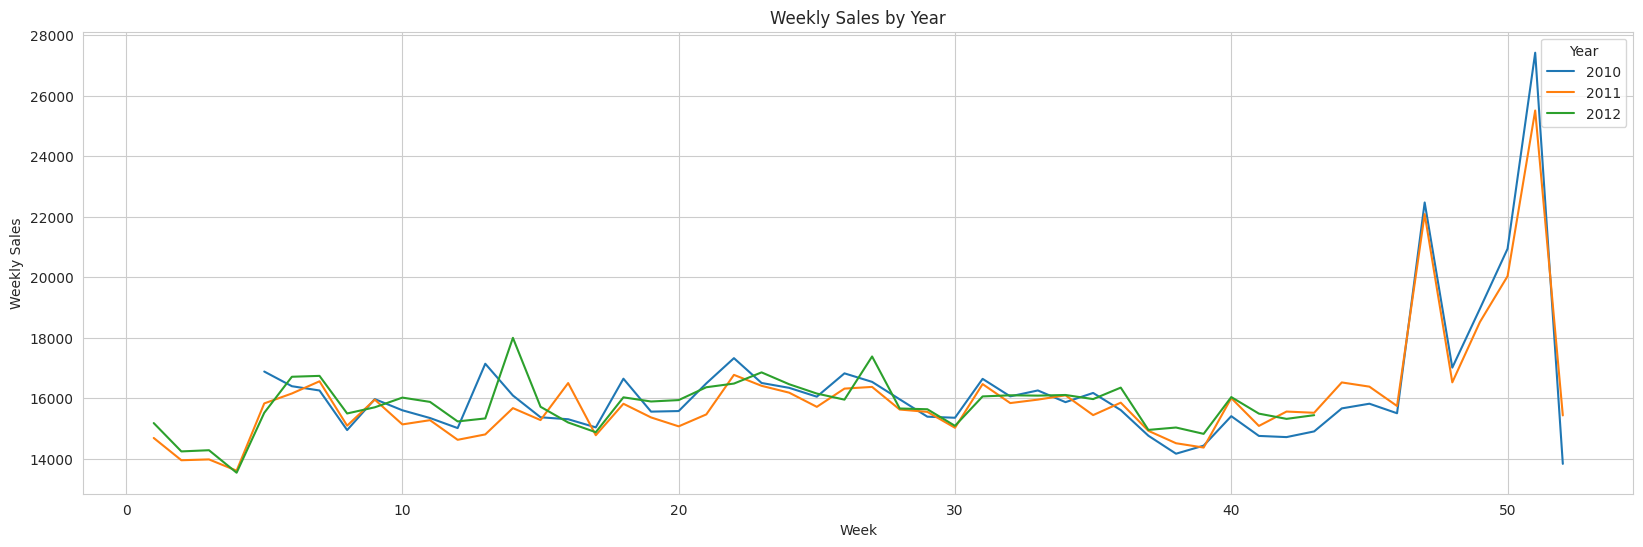

In [371]:
#Plotting weekly sales by year
weekly_sales_by_month = pd.pivot_table(df, values = "Weekly_Sales", columns = "Year", index = "Week")
weekly_sales_by_month.plot(figsize=(20,6))
plt.title('Weekly Sales by Year')
plt.xlabel('Week')
plt.ylabel('Weekly Sales')
plt.show()

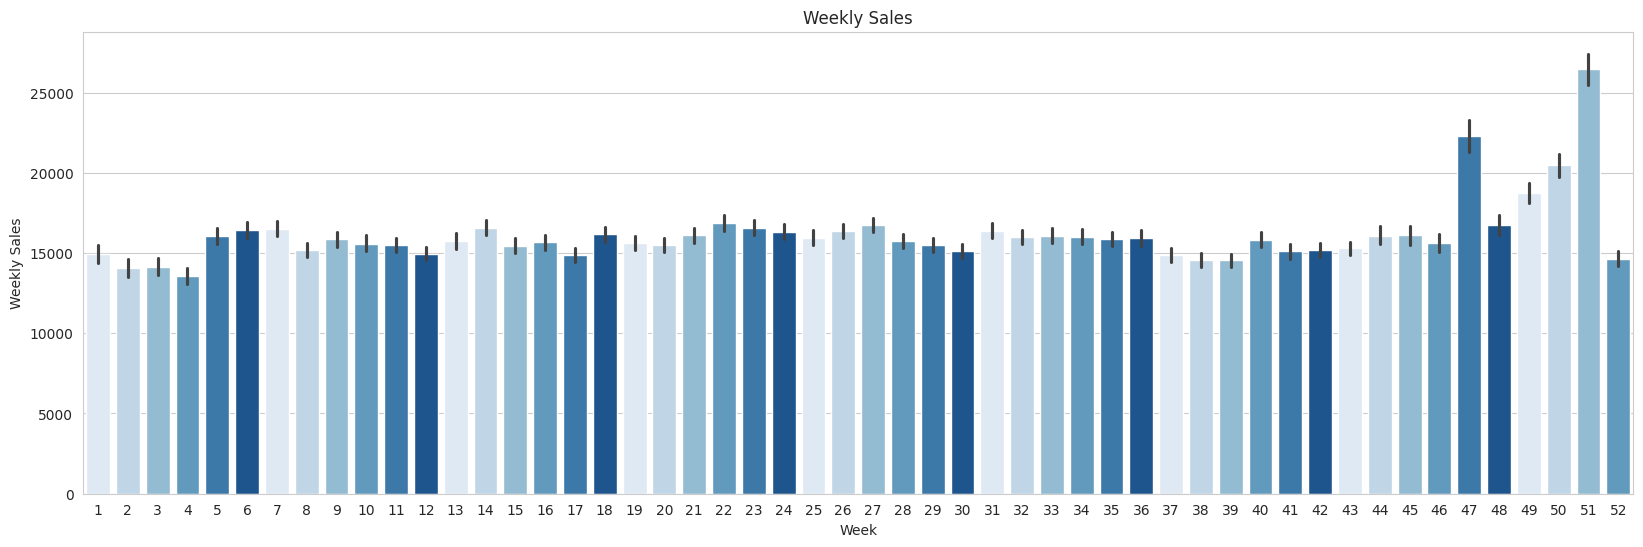

In [372]:
#Plotting weekly sales
plt.figure(figsize=(20,6)) # Create a figure with the desired figsize
weekly_sales= sns.barplot(x='Week', y='Weekly_Sales', data=df,
                  palette=sns.color_palette("Blues"))
plt.title('Weekly Sales')
plt.xlabel('Week')
plt.ylabel('Weekly Sales')
plt.show()

In [373]:
#Confirming the top 5 highest weekly sales
df.groupby('Week')['Weekly_Sales'].mean().sort_values(ascending=False).head()

,Weekly_Sales
Week,
51,26449.733674
47,22269.601768
50,20478.421134
49,18731.794840
22,16852.791563


We can conclude that analyzing the monthly and weekly graphs by year shows the same pattern over three different years: low sales at the beginning of the year and high sales at the end.

**Step 9 - Checking the last variables**

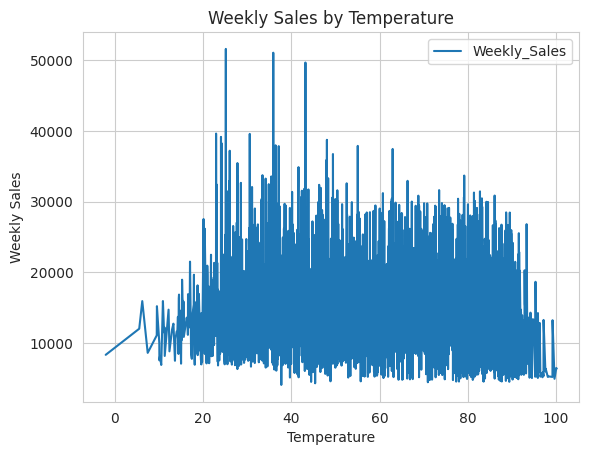

In [374]:
#Wekkly sales by temperature
weekly_sales_by_temperature = pd.pivot_table(df, values = "Weekly_Sales", index = "Temperature")
weekly_sales_by_temperature.plot()
plt.title('Weekly Sales by Temperature')
plt.xlabel('Temperature')
plt.ylabel('Weekly Sales')
plt.show()

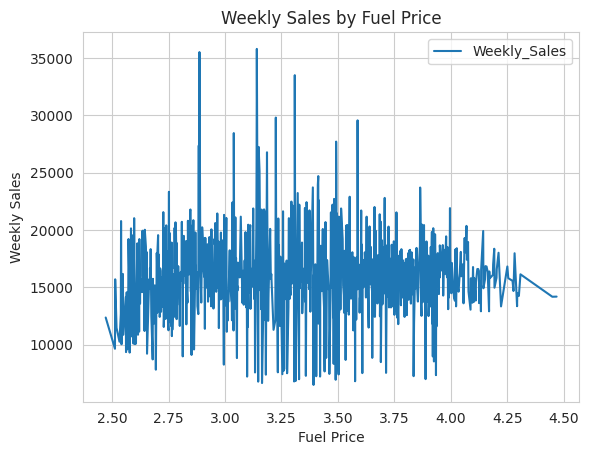

In [375]:
#Wekkly sales by fuel price
weekly_sales_by_fuel_price = pd.pivot_table(df, values = "Weekly_Sales", index = "Fuel_Price")
weekly_sales_by_fuel_price.plot()
plt.title('Weekly Sales by Fuel Price')
plt.xlabel('Fuel Price')
plt.ylabel('Weekly Sales')
plt.show()

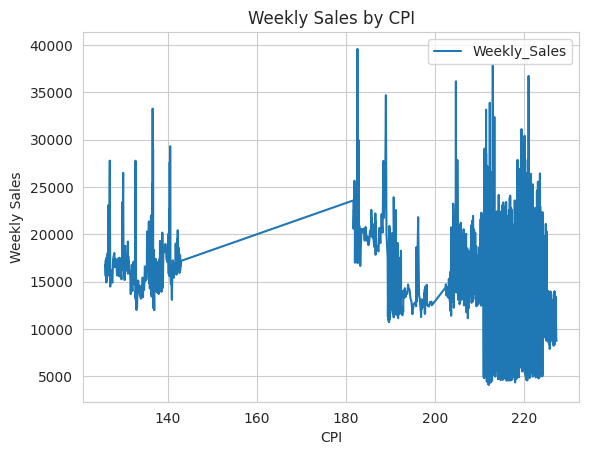

In [376]:
#Wekkly sales by CPI
weekly_sales_by_cpi = pd.pivot_table(df, values = "Weekly_Sales", index = "CPI")
weekly_sales_by_cpi.plot()
plt.title('Weekly Sales by CPI')
plt.xlabel('CPI')
plt.ylabel('Weekly Sales')
plt.show()

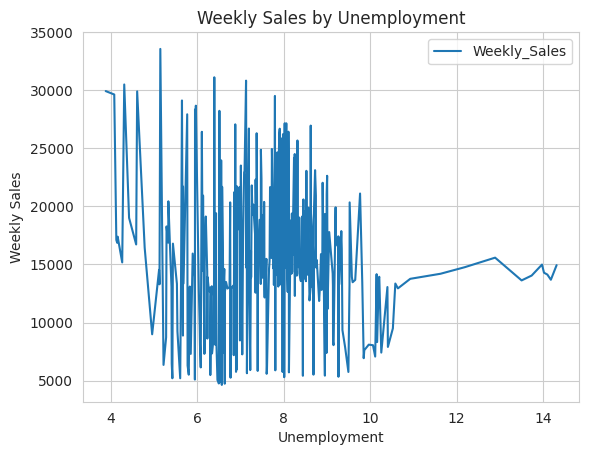

In [377]:
#Wekkly sales by Unemployment
weekly_sales_by_unemployment = pd.pivot_table(df, values = "Weekly_Sales", index = "Unemployment")
weekly_sales_by_unemployment.plot()
plt.title('Weekly Sales by Unemployment')
plt.xlabel('Unemployment')
plt.ylabel('Weekly Sales')
plt.show()

Analyzing these graphs, I have only one observation: there's no data between 140 and 180.

**Step 10 - Manipulating the cleaned data**

In [378]:
#Cheking the cleaned dataset
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,Unemployment,Type,Size,Year,Month,Week,Super_Bowl,Labor_Day,Thanksgiving_Day,New_Years_Eve
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,...,8.106,A,151315,2010,2,5,False,False,False,False
1,1,1,2010-02-12,46039.49,True,38.51,2.548,0.0,0.0,0.0,...,8.106,A,151315,2010,2,6,True,False,False,False
2,1,1,2010-02-19,41595.55,False,39.93,2.514,0.0,0.0,0.0,...,8.106,A,151315,2010,2,7,False,False,False,False
3,1,1,2010-02-26,19403.54,False,46.63,2.561,0.0,0.0,0.0,...,8.106,A,151315,2010,2,8,False,False,False,False
4,1,1,2010-03-05,21827.90,False,46.50,2.625,0.0,0.0,0.0,...,8.106,A,151315,2010,3,9,False,False,False,False


In [379]:
#Checking general information
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 420285 entries, 0 to 421569
Data columns (total 23 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Store             420285 non-null  int64         
 1   Dept              420285 non-null  int64         
 2   Date              420285 non-null  datetime64[ns]
 3   Weekly_Sales      420285 non-null  float64       
 4   IsHoliday         420285 non-null  bool          
 5   Temperature       420285 non-null  float64       
 6   Fuel_Price        420285 non-null  float64       
 7   MarkDown1         420285 non-null  float64       
 8   MarkDown2         420285 non-null  float64       
 9   MarkDown3         420285 non-null  float64       
 10  MarkDown4         420285 non-null  float64       
 11  MarkDown5         420285 non-null  float64       
 12  CPI               420285 non-null  float64       
 13  Unemployment      420285 non-null  float64       
 14  Type     

In [380]:
#Transforming store types into numerical values
store_type = {'A': 1, 'B': 2, 'C': 3}
df['Type'] = df['Type'].replace(store_type)

In [381]:
#Transforming boolean columns into integer columns
df['IsHoliday'] = df['IsHoliday'].astype(int)
df['Super_Bowl'] = df['Super_Bowl'].astype(int)
df['Labor_Day'] = df['Labor_Day'].astype(int)
df['Thanksgiving_Day'] = df['Thanksgiving_Day'].astype(int)
df['New_Years_Eve'] = df['New_Years_Eve'].astype(int)

In [382]:
#Checking again general information
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 420285 entries, 0 to 421569
Data columns (total 23 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Store             420285 non-null  int64         
 1   Dept              420285 non-null  int64         
 2   Date              420285 non-null  datetime64[ns]
 3   Weekly_Sales      420285 non-null  float64       
 4   IsHoliday         420285 non-null  int64         
 5   Temperature       420285 non-null  float64       
 6   Fuel_Price        420285 non-null  float64       
 7   MarkDown1         420285 non-null  float64       
 8   MarkDown2         420285 non-null  float64       
 9   MarkDown3         420285 non-null  float64       
 10  MarkDown4         420285 non-null  float64       
 11  MarkDown5         420285 non-null  float64       
 12  CPI               420285 non-null  float64       
 13  Unemployment      420285 non-null  float64       
 14  Type     

**Step 11 - Exploring the available data**

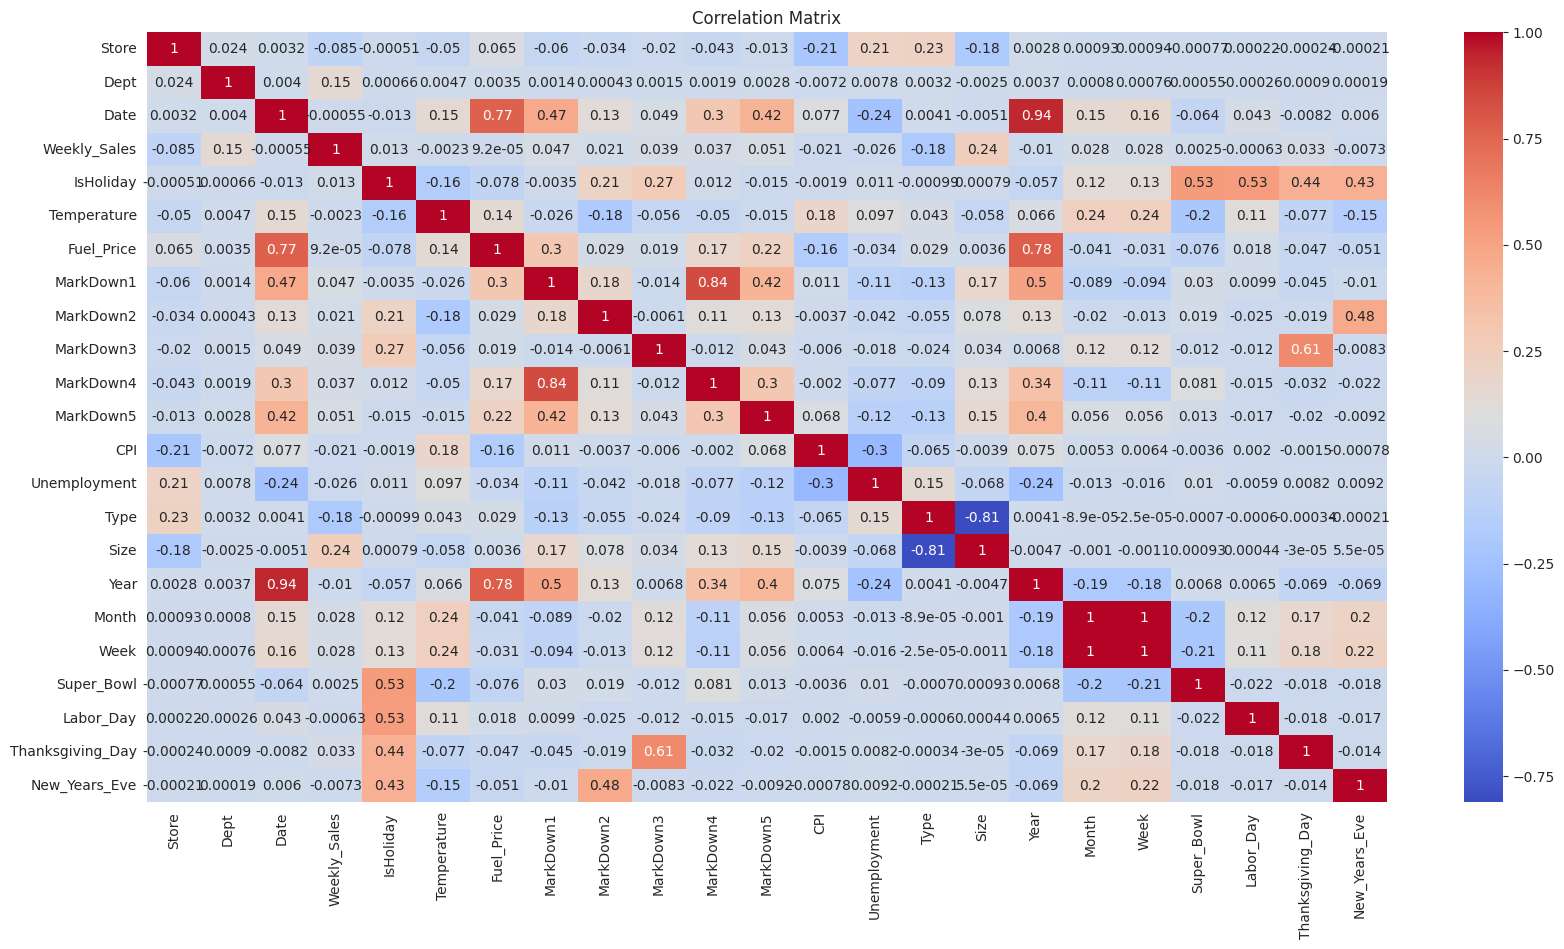

In [383]:
#Correlation matrix
plt.figure(figsize=(20, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [384]:
#Numeric correlation matrix
correlation_matrix = df.select_dtypes(include=np.number).corr()['Weekly_Sales']
target_correlation = np.abs(correlation_matrix)
print(target_correlation.sort_values(ascending=False))

Weekly_Sales        1.000000
Size                0.244089
Type                0.182222
Dept                0.148704
Store               0.085099
MarkDown5           0.050612
MarkDown1           0.047260
MarkDown3           0.038530
MarkDown4           0.037481
Thanksgiving_Day    0.032885
Month               0.028431
Week                0.027689
Unemployment        0.025831
CPI                 0.021153
MarkDown2           0.020961
IsHoliday           0.012856
Year                0.010004
New_Years_Eve       0.007344
Super_Bowl          0.002498
Temperature         0.002333
Labor_Day           0.000632
Fuel_Price          0.000092
Name: Weekly_Sales, dtype: float64


**Step 12 - Applying Machine Learning Algorithm**

In [385]:
#Sort the DataFrame by the 'Date' column in ascending (chronological) order
df = df.sort_values(by='Date', ascending=True)

In [386]:
#Splitting the dataset into 70% training and 30% testing sets
train_df = df[:int(0.7*(len(df)))]
test_df = df[int(0.7*(len(df))):]

#Defining the target variable
target = 'Weekly_Sales'

#Selecting all feature columns by dropping the target
features = df.drop(columns=['Weekly_Sales']).columns

#Extracting training and testing data for features and target
X_train = train_df.loc[:, features]
X_test = test_df.loc[:, features]
y_train = train_df.loc[:, target]
y_test = test_df.loc[:, target]

#Creating a variable X by selecting only the feature columns from the dataset
X = df[features]

#Dropping the 'Date' column from the training and testing feature sets
X_train = X_train.drop(['Date'], axis=1)
X_test = X_test.drop(['Date'], axis=1)

In [387]:
#Defining a function to calculate the Weighted Mean Absolute Error (WMAE), giving higher weight to holiday weeks
def wmae_test(test, pred):
    weights = X_test['IsHoliday'].apply(lambda is_holiday:5 if is_holiday else 1)
    error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
    return error

In [388]:
#Creating a Random Forest Regressor model with specific hyperparameters
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=35,
                           max_features='sqrt', min_samples_split=10)

#Creating a RobustScaler to normalize the features while handling outliers
scaler = RobustScaler()

#Creating a pipeline combining the scaler and the regressor
pipe = make_pipeline(scaler, rf)

#Fitting the pipeline on the training data
pipe.fit(X_train, y_train)

#Predicting on the training set
y_pred = pipe.predict(X_train)

#Predicting on the testing set
y_pred_test = pipe.predict(X_test)

#Calculating the Weighted Mean Absolute Error (WMAE) on the test set predictions
wmae_test(y_test, y_pred_test)

np.float64(7669.671200609282)

In [389]:
#Creating a Decision Tree Regressor model and fitting it on the training data
dt_model = DecisionTreeRegressor()
dt_model.fit(X_train, y_train)

#Performing 5-fold cross-validation to evaluate the model's performance using negative mean squared error
scores = cross_val_score(dt_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

#Dropping the 'Date' column from the feature set
X = X.drop(['Date'], axis=1)

In [390]:
#Extracting the feature importances from the trained Random Forest model
importances = rf.feature_importances_

#Calculating the standard deviation of the feature importances across all trees
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

#Sorting the features by importance in descending order
indices = np.argsort(importances)[::-1]

#Storing the feature names for display
feature_names = X.columns

#Printing the ranking of features by importance
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, feature_names[indices[f]], importances[indices[f]]))

Feature ranking:
1. Dept (0.743598)
2. Size (0.081998)
3. Store (0.039267)
4. Type (0.030709)
5. CPI (0.026161)
6. Unemployment (0.019084)
7. Week (0.013335)
8. Temperature (0.013151)
9. Fuel_Price (0.011423)
10. Month (0.005708)
11. MarkDown3 (0.003732)
12. MarkDown4 (0.001902)
13. MarkDown5 (0.001779)
14. MarkDown1 (0.001759)
15. MarkDown2 (0.001633)
16. Thanksgiving_Day (0.001432)
17. IsHoliday (0.001105)
18. Year (0.001032)
19. New_Years_Eve (0.000677)
20. Super_Bowl (0.000258)
21. Labor_Day (0.000257)


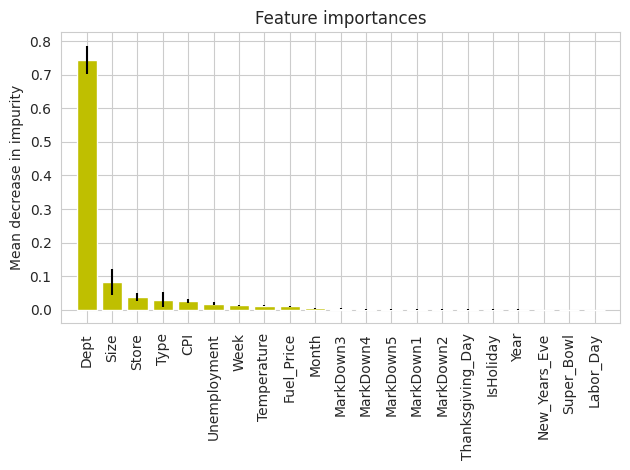

In [391]:
#Plotting the feature importances along with the standard deviation
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="y", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.ylabel("Mean decrease in impurity")
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.show()

In [392]:
#Dropping irrelevant columns from the training and testing feature sets
X1_train = X_train.drop(['Month', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'MarkDown1', 'MarkDown2', 'Thanksgiving_Day', 'IsHoliday', 'Year', 'New_Years_Eve', 'Super_Bowl', 'Labor_Day'], axis=1)
X1_test = X_test.drop(['Month', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'MarkDown1', 'MarkDown2', 'Thanksgiving_Day', 'IsHoliday', 'Year', 'New_Years_Eve', 'Super_Bowl', 'Labor_Day'], axis=1)

In [393]:
#Creating a Random Forest Regressor model with specific hyperparameters
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=35,
                           max_features='sqrt', min_samples_split=10)

#Defining a RobustScaler to normalize the data, reducing the influence of outliers
scaler = RobustScaler()

#Creating a pipeline to apply scaling followed by training the model
pipe = make_pipeline(scaler, rf)

#Fitting the pipeline on the training data
pipe.fit(X1_train, y_train)

#Predicting on the training data
y_pred = pipe.predict(X1_train)

#Predicting on the test data
y_pred_test = pipe.predict(X1_test)

#Calculating the Weighted Mean Absolute Error (WMAE) on the test set predictions
wmae_test(y_test, y_pred_test)

np.float64(4612.315759117192)

In [394]:
#Dropping irrelevant columns from the training and testing feature sets
X2_train = X_train.drop(['Month', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'MarkDown1', 'MarkDown2', 'Thanksgiving_Day', 'IsHoliday', 'Year', 'New_Years_Eve', 'Super_Bowl', 'Labor_Day','CPI', 'Unemployment', 'Week', 'Temperature', 'Fuel_Price'], axis=1, errors='ignore')
X2_test = X_test.drop(['Month', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'MarkDown1', 'MarkDown2', 'Thanksgiving_Day', 'IsHoliday', 'Year', 'New_Years_Eve', 'Super_Bowl', 'Labor_Day','CPI', 'Unemployment', 'Week', 'Temperature', 'Fuel_Price'], axis=1, errors='ignore')

In [395]:
#Creating the Random Forest model with specific hyperparameters
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=35,
                           max_features='sqrt', min_samples_split=10)

#Creating the pipeline with RobustScaler and the Random Forest model
scaler = RobustScaler()
pipe = make_pipeline(scaler, rf)

#Fitting the pipeline on the training data
pipe.fit(X2_train, y_train)

#Predicting on the training set
y_pred = pipe.predict(X2_train)

#Predicting on the test set
y_pred_test = pipe.predict(X2_test)

#Calculating the weighted mean absolute error on the test set
wmae_test(y_test, y_pred_test)

np.float64(2713.3935314139426)

In [396]:
# Creating an empty DataFrame to store model names and their WMAE values
df_results = pd.DataFrame(columns=["Model", 'WMAE'])

# Appending the baseline model result to the DataFrame
df_results = pd.concat([df_results, pd.DataFrame([{
     "Model": 'Baseline with all the data',
     'WMAE': 7670}])], ignore_index=True)

# Appending the result of a model without weak features (first variation)
df_results = pd.concat([df_results, pd.DataFrame([{
     "Model": 'Without weak features (first variation)',
     'WMAE': 4612}])], ignore_index=True)

# Appending the result of another model without weak features (second variation)
df_results = pd.concat([df_results, pd.DataFrame([{
     "Model": 'Without weak features (second variation)',
     'WMAE': 2713}])], ignore_index=True)

# Displaying the final DataFrame with model comparisons
df_results

,Model,WMAE
0,Baseline with all the data,7670
1,Without weak features (first variation),4612
2,Without weak features (second variation),2713


WMAE stands for Weighted Mean Absolute Error. It’s an evaluation metric used to measure the accuracy of predictions, giving more importance to some errors than others. In this case, I tested three different models and compared their WMAE values. The third model performed the best, as it had the lowest WMAE.

In [397]:
#Displaying the first 5 rows of the DataFrame
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,Unemployment,Type,Size,Year,Month,Week,Super_Bowl,Labor_Day,Thanksgiving_Day,New_Years_Eve
0,1,1,2010-02-05,24924.50,0,42.31,2.572,0.0,0.0,0.0,...,8.106,1,151315,2010,2,5,0,0,0,0
224669,23,79,2010-02-05,35265.03,0,15.25,2.788,0.0,0.0,0.0,...,5.892,2,114533,2010,2,5,0,0,0,0
224660,23,78,2010-02-05,12.00,0,15.25,2.788,0.0,0.0,0.0,...,5.892,2,114533,2010,2,5,0,0,0,0
187907,20,5,2010-02-05,56536.02,0,25.92,2.784,0.0,0.0,0.0,...,8.187,1,203742,2010,2,5,0,0,0,0
152265,16,32,2010-02-05,3852.56,0,19.79,2.580,0.0,0.0,0.0,...,7.039,2,57197,2010,2,5,0,0,0,0


In [398]:
#Converting the 'Date' column to datetime format
df["Date"] = pd.to_datetime(df["Date"])

#Setting 'Date' as the index of the DataFrame
df.set_index('Date', inplace=True)

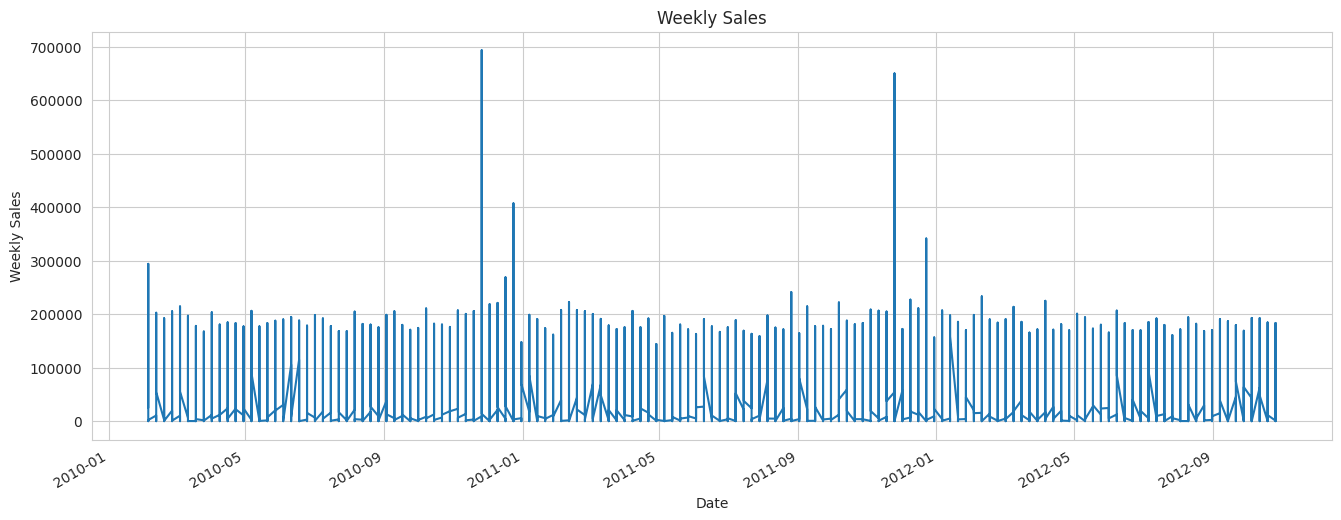

In [399]:
#Creating a figure and plotting the 'Weekly_Sales' time series
plt.figure(figsize=(16,6))
df['Weekly_Sales'].plot()
plt.title('Weekly Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.show()

In [400]:
#Resampling the data by week and calculating the weekly mean
df_week = df.resample('W').mean()

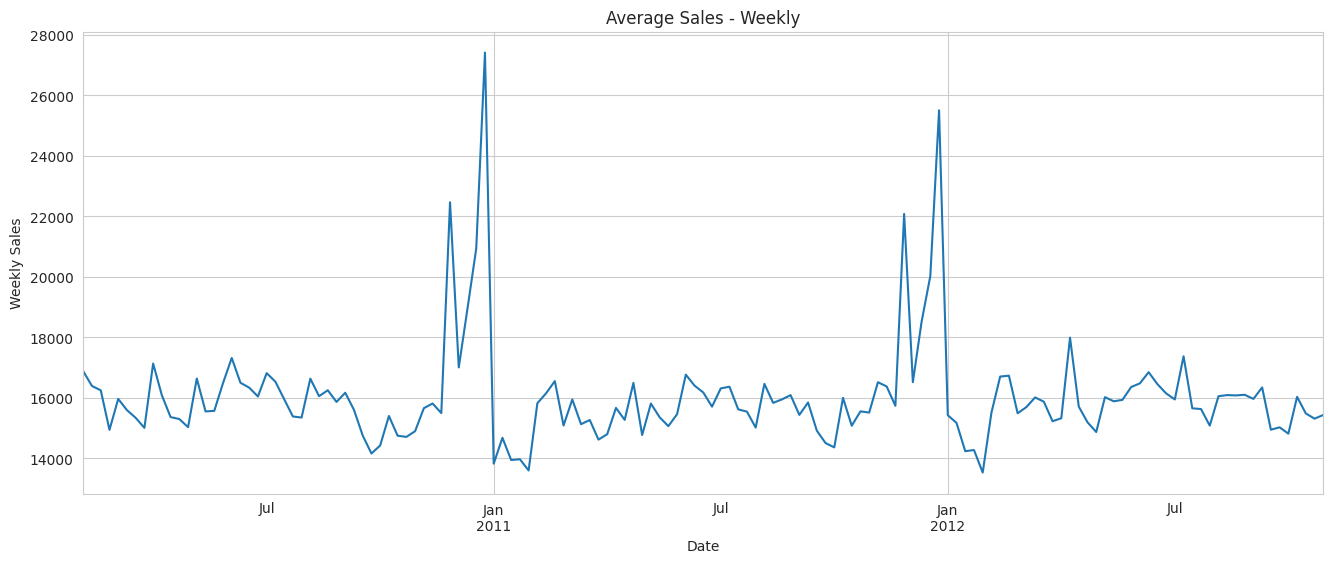

In [401]:
#Plotting the resampled weekly average sales
plt.figure(figsize=(16,6))
df_week['Weekly_Sales'].plot()
plt.title('Average Sales - Weekly')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.show()

In [402]:
#Resampling the data by month and calculating the monthly mean
df_month = df.resample('MS').mean()

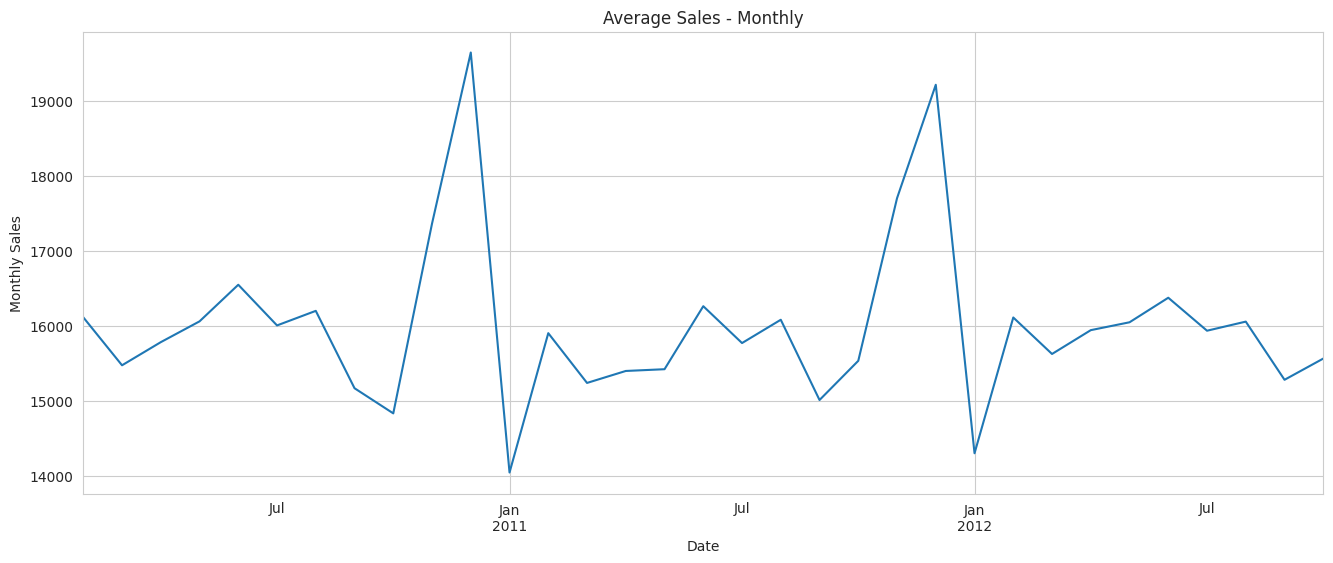

In [403]:
#Plotting the monthly average sales
plt.figure(figsize=(16,6))
df_month['Weekly_Sales'].plot()
plt.title('Average Sales - Monthly')
plt.xlabel('Date')
plt.ylabel('Monthly Sales')
plt.show()

By analyzing the weekly data by month, I can more clearly see a certain seasonal pattern.

In [404]:
#Calculating the rolling mean and rolling standard deviation for the weekly sales
roll_mean = df_week['Weekly_Sales'].rolling(window=2, center=False).mean()
roll_std = df_week['Weekly_Sales'].rolling(window=2, center=False).std()

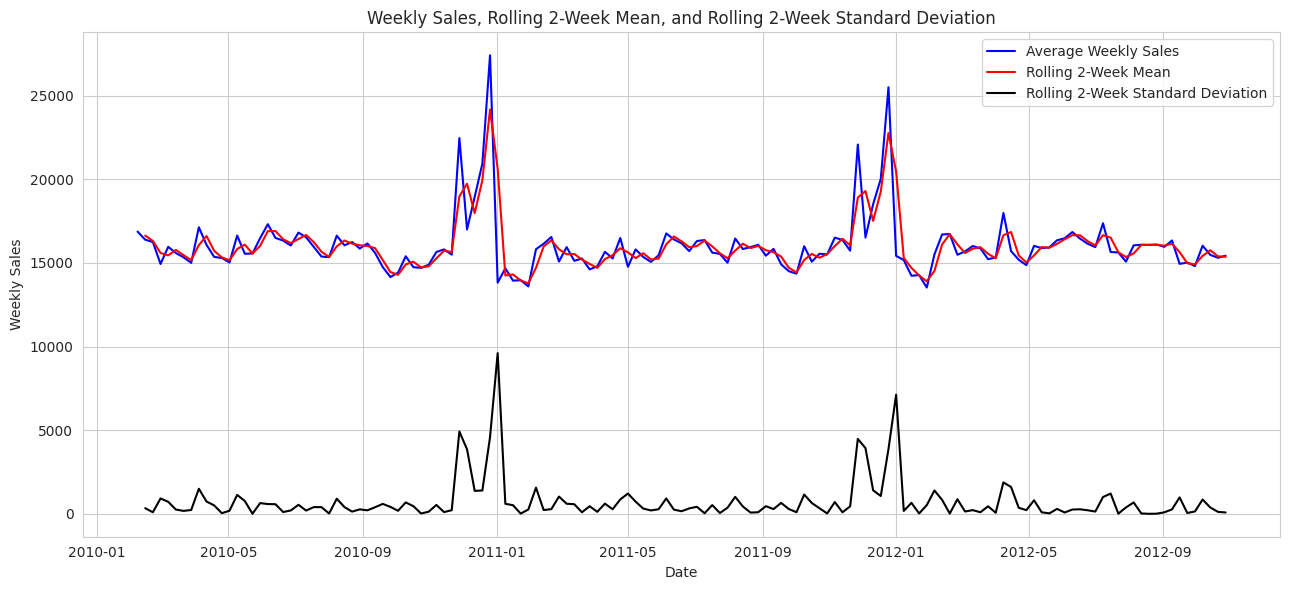

In [405]:
#Plotting the weekly sales, rolling 2-week mean, and rolling 2-week standard deviation
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week['Weekly_Sales'], color='blue', label='Average Weekly Sales')
ax.plot(roll_mean, color='red', label='Rolling 2-Week Mean')
ax.plot(roll_std, color='black', label='Rolling 2-Week Standard Deviation')
plt.title('Weekly Sales, Rolling 2-Week Mean, and Rolling 2-Week Standard Deviation')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
ax.legend()
fig.tight_layout()

In [406]:
#Running the Augmented Dickey-Fuller test on the weekly sales data
adfuller(df_week['Weekly_Sales'])

(np.float64(-5.927437652782706),
 np.float64(2.424917229727461e-07),
 4,
 138,
 {'1%': np.float64(-3.47864788917503),
  '5%': np.float64(-2.882721765644168),
  '10%': np.float64(-2.578065326612056)},
 np.float64(2261.6032243639706))

In [407]:
#Splitting the weekly sales data into training and testing datasets
train_data = df_week[:int(0.7*(len(df_week)))]
test_data = df_week[int(0.7*(len(df_week))):]

#Printing the shapes of the train and test datasets
print('Train:', train_data.shape)
print('Test:', test_data.shape)

Train: (100, 22)
Test: (43, 22)


In [408]:
#Defining the target variable (Weekly Sales)
target = "Weekly_Sales"

#Creating the list of columns to be used as features, excluding the target column
features = [c for c in df_week.columns.to_list() if c not in [target]]

#Selecting the features for the training and testing datasets
X_train = train_data[features]
X_test = test_data[features]

#Selecting the target variable for the training and testing datasets
y_train = train_data[target]
y_test = test_data[target]

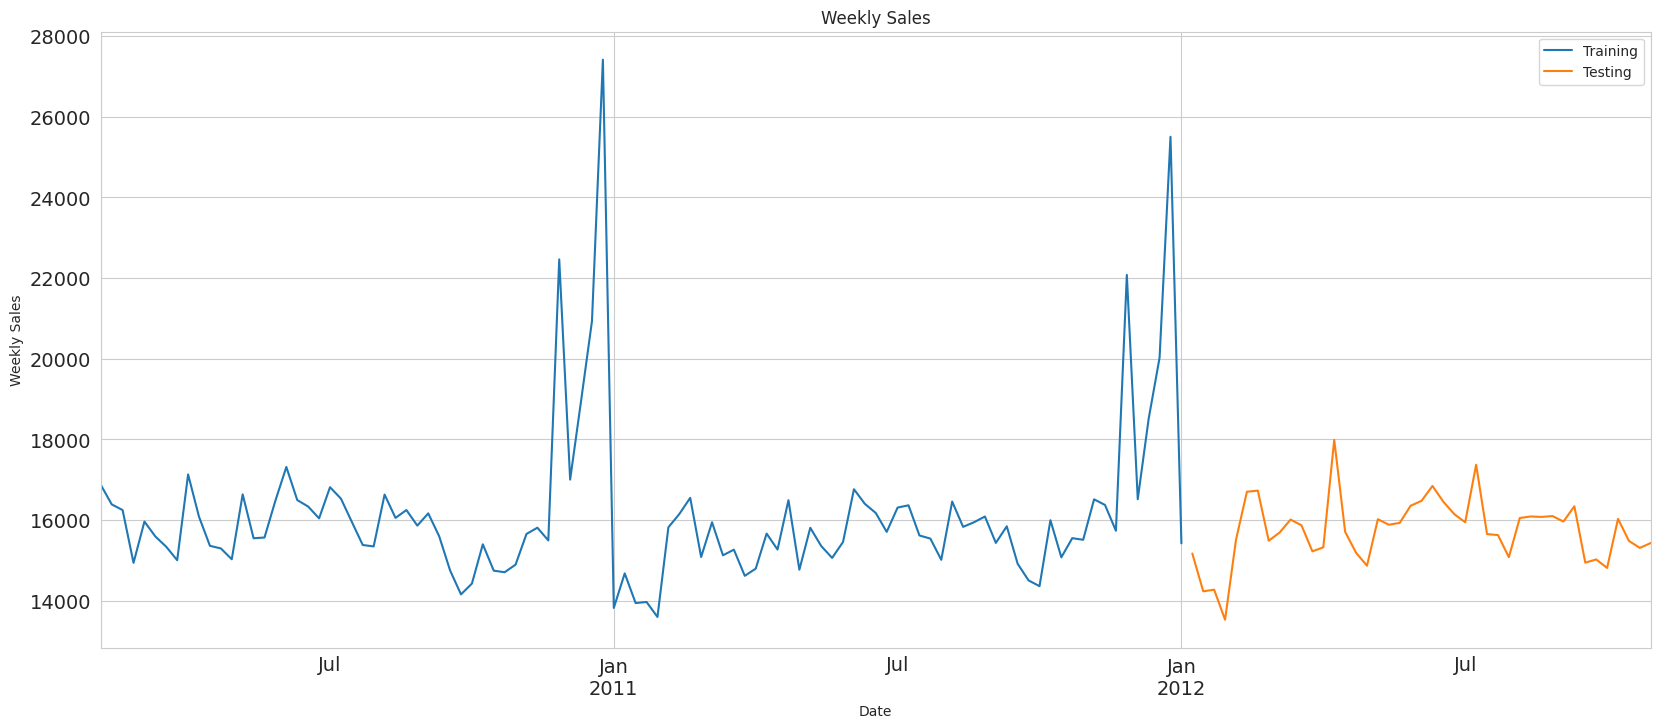

In [409]:
#Plotting Weekly Sales for the training data with a label
train_data['Weekly_Sales'].plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14, label='Training')

#Plotting Weekly Sales for the testing data with a label
test_data['Weekly_Sales'].plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14, label='Testing')
plt.legend()
plt.title('Weekly Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.show()

In [410]:
#Decomposing the weekly sales data into seasonal, trend, and residual components
decomposed = seasonal_decompose(df_week['Weekly_Sales'], model='additive', period=20)

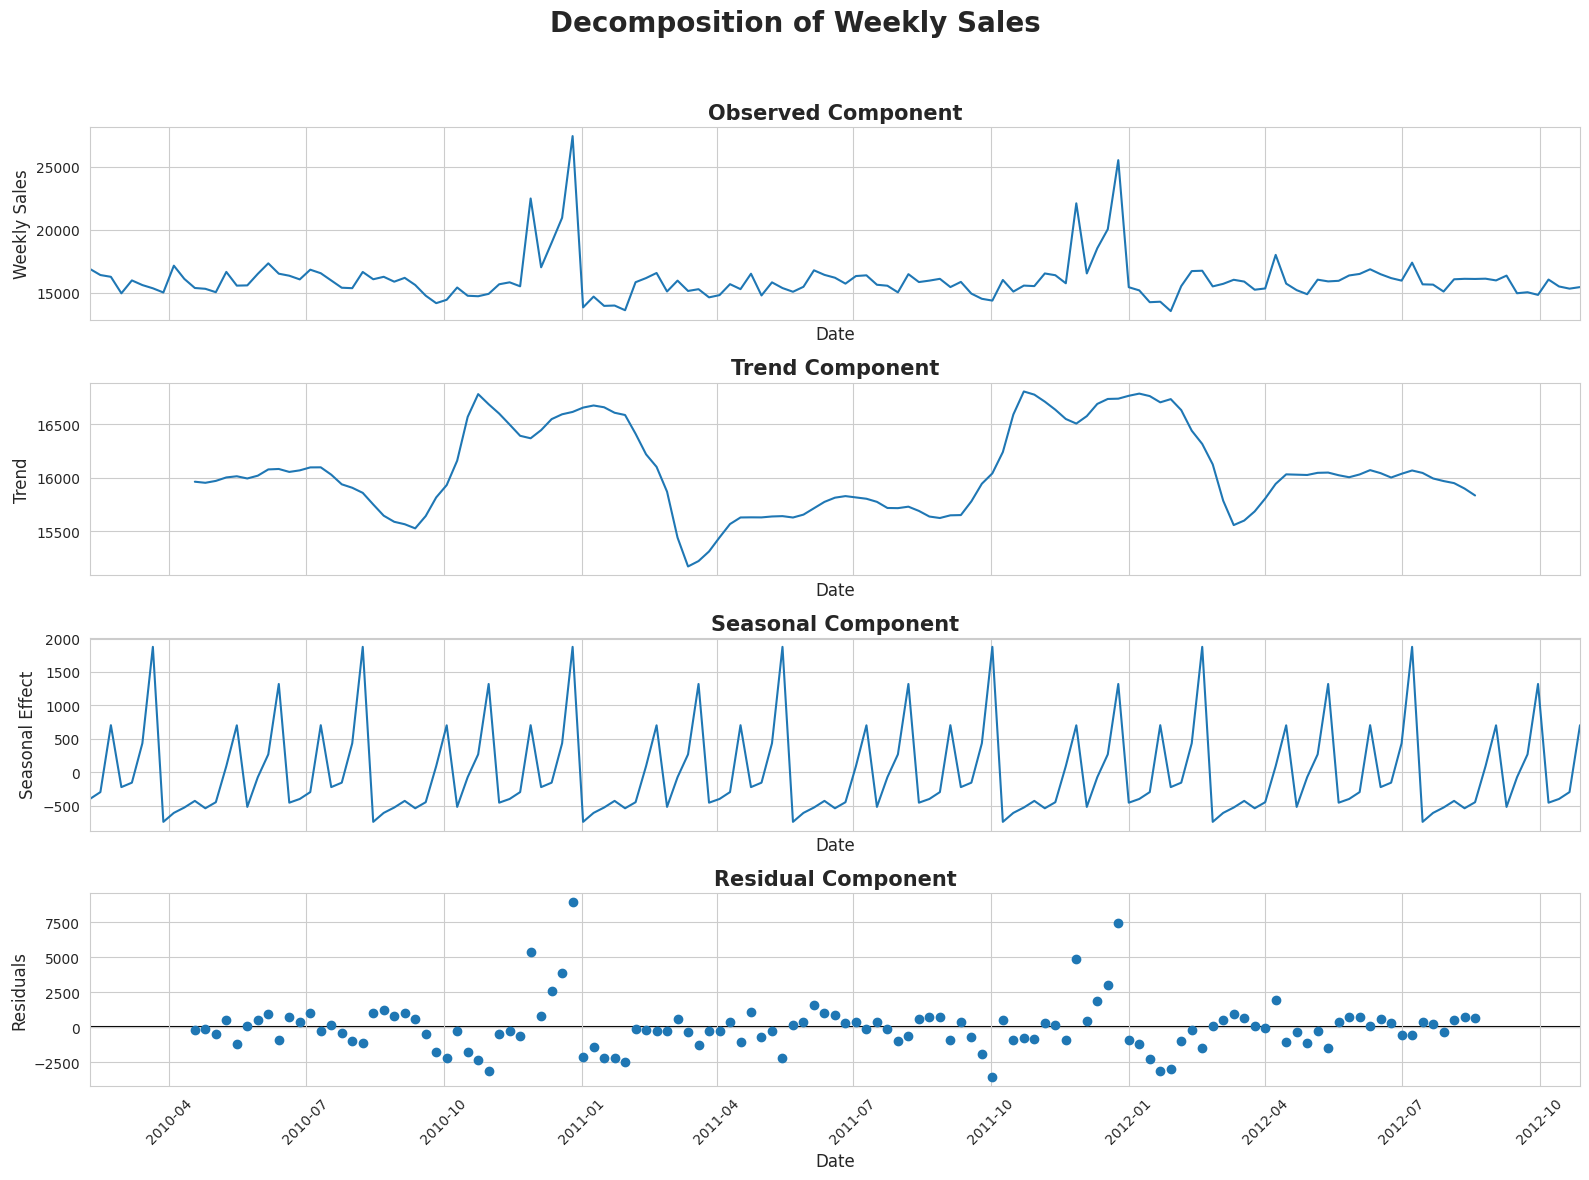

In [411]:
#Plotting the decomposed components
fig = decomposed.plot()
fig.set_size_inches(16, 12)
fig.suptitle('Decomposition of Weekly Sales', fontsize=20, weight='bold')
axes = fig.axes
titles = ['Observed Component', 'Trend Component', 'Seasonal Component', 'Residual Component']
ylabels = ['Weekly Sales', 'Trend', 'Seasonal Effect', 'Residuals']

for ax, title, ylabel in zip(axes, titles, ylabels):
    ax.set_title(title, fontsize=15, weight='semibold')
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_xlabel('Date', fontsize=12)
    ax.tick_params(axis='x', labelrotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [412]:
#Applying first-order differencing to make the time series stationary
df_week_diff = df_week['Weekly_Sales'].diff().dropna()

# Calculating rolling mean of the differenced series using a 2-week window
diff_roll_mean = df_week_diff.rolling(window=2, center=False).mean()

# Calculating rolling standard deviation of the differenced series using a 2-week window
diff_roll_std = df_week_diff.rolling(window=2, center=False).std()

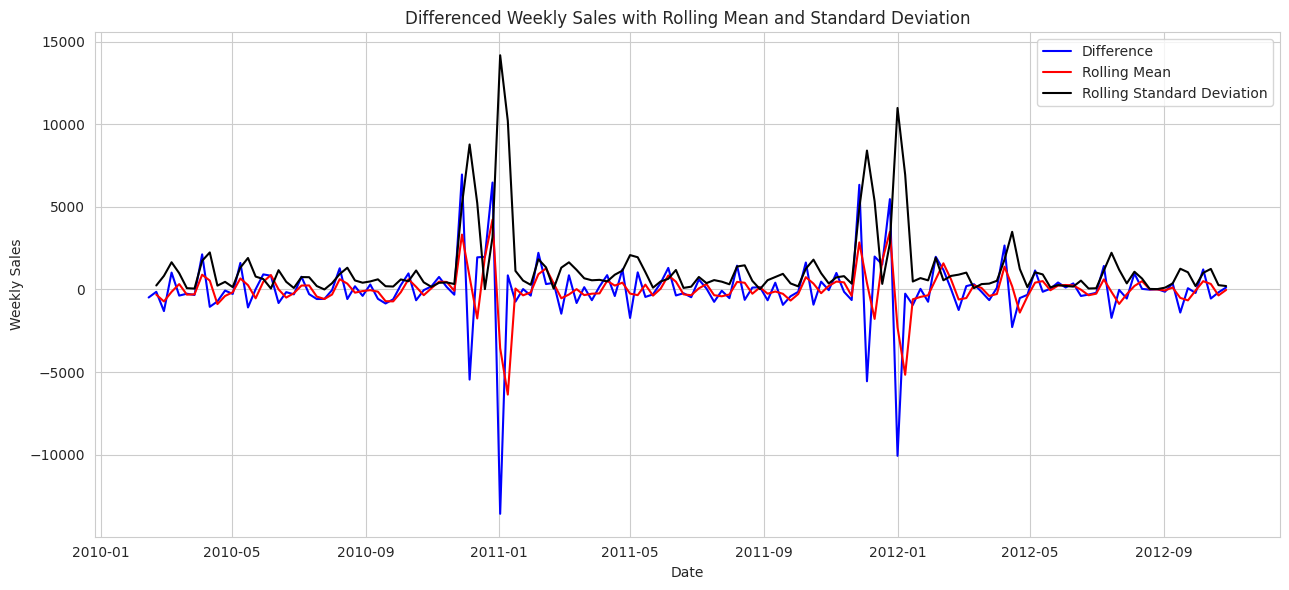

In [413]:
#Showing the differenced time series along with its rolling mean and rolling standard deviation
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week_diff, color='blue', label='Difference')
ax.plot(diff_roll_mean, color='red', label='Rolling Mean')
ax.plot(diff_roll_std, color='black', label='Rolling Standard Deviation')
ax.legend()
ax.set_title('Differenced Weekly Sales with Rolling Mean and Standard Deviation')
ax.set_xlabel('Date')
ax.set_ylabel('Weekly Sales')
fig.tight_layout()

In [414]:
#Creating a lagged version of the weekly sales time series to help checking autocorrelation
df_week_lag = df_week['Weekly_Sales'].shift().dropna()

#Calculating the rolling mean and standard deviation for the lagged weekly sales to analyze its trend over time
lag_roll_mean = df_week_lag.rolling(window=2, center=False).mean()
lag_roll_std = df_week_lag.rolling(window=2, center=False).std()

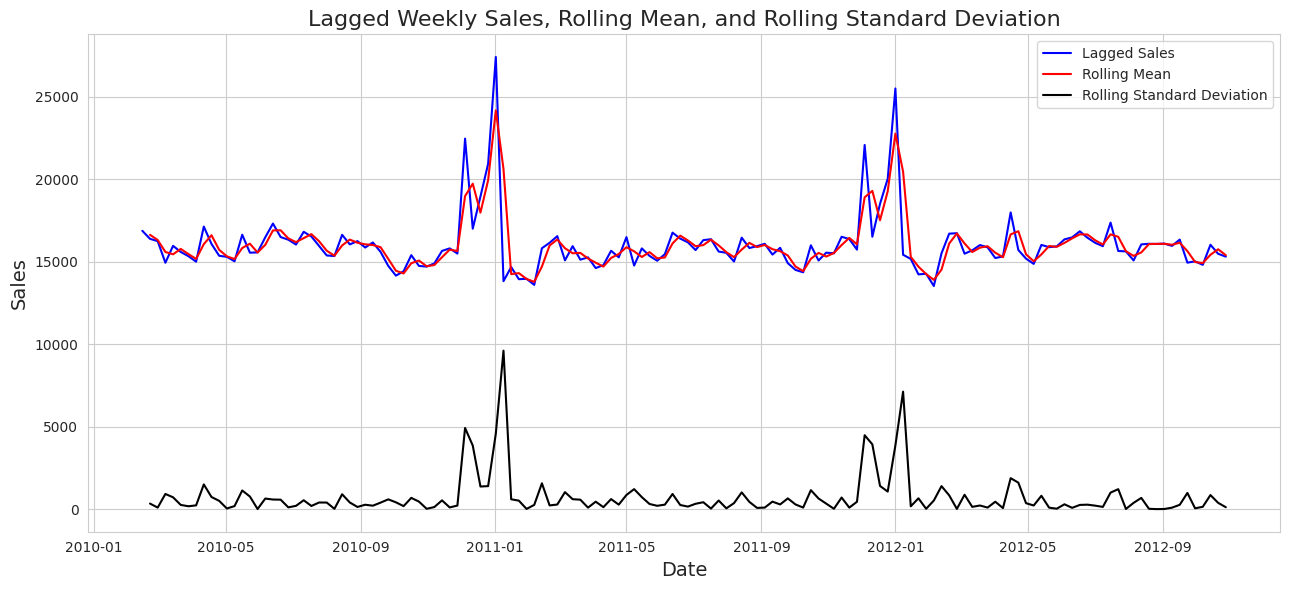

In [415]:
#Plotting the lagged weekly sales data along with its rolling mean and standard deviation to analyze its behavior over time
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week_lag, color='blue', label='Lagged Sales')
ax.plot(lag_roll_mean, color='red', label='Rolling Mean')
ax.plot(lag_roll_std, color='black', label='Rolling Standard Deviation')
ax.legend()
ax.set_title('Lagged Weekly Sales, Rolling Mean, and Rolling Standard Deviation', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Sales', fontsize=14)
fig.tight_layout()
plt.show()

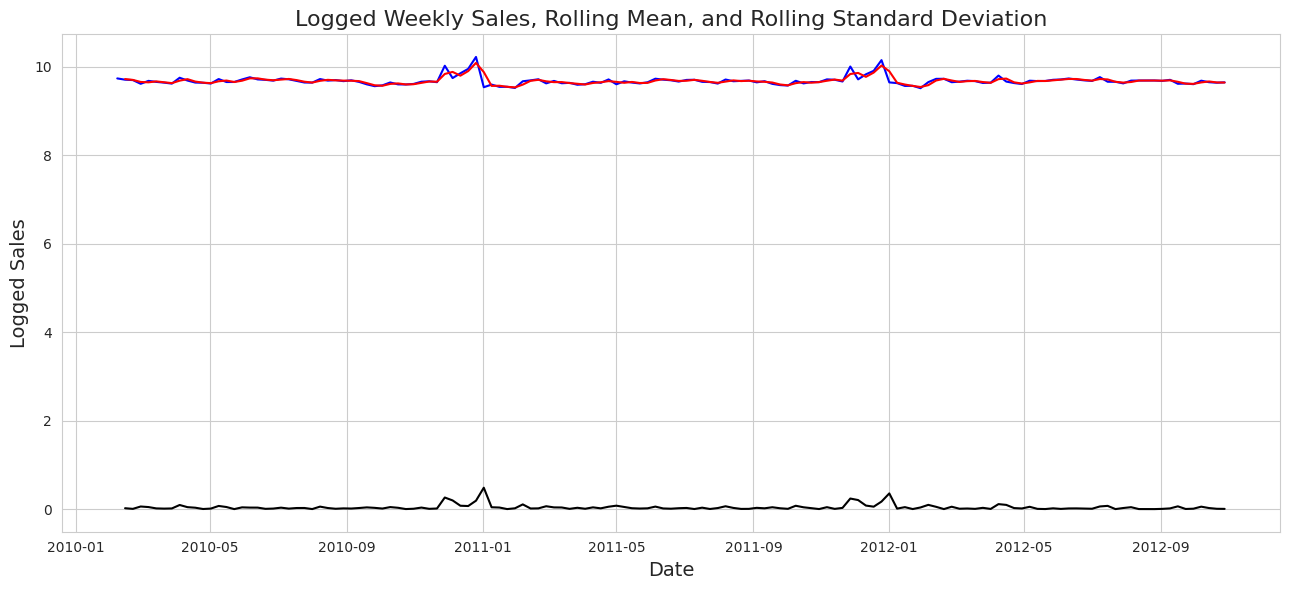

In [416]:
#Applying the log transformation to the 'Weekly_Sales' column using log1p (log(1 + x)) to handle zero values in the data
logged_week = np.log1p(df_week['Weekly_Sales']).dropna()

#Calculating the rolling mean and standard deviation for the logged data with a window size of 2
log_roll_mean = logged_week.rolling(window=2, center=False).mean()
log_roll_std = logged_week.rolling(window=2, center=False).std()

#Plotting the logged weekly sales data, its rolling mean and rolling standard deviation
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(logged_week, color='blue', label='Logged')
ax.plot(log_roll_mean, color='red', label='Rolling Mean')
ax.plot(log_roll_std, color='black', label='Rolling Standard Deviation')
ax.set_title('Logged Weekly Sales, Rolling Mean, and Rolling Standard Deviation', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Logged Sales', fontsize=14)
fig.tight_layout()
plt.show()

In [417]:
#Splitting the differenced data into training and testing sets
train_data_diff = df_week_diff[:int(0.7*(len(df_week_diff)))]
test_data_diff = df_week_diff[int(0.7*(len(df_week_diff))):]

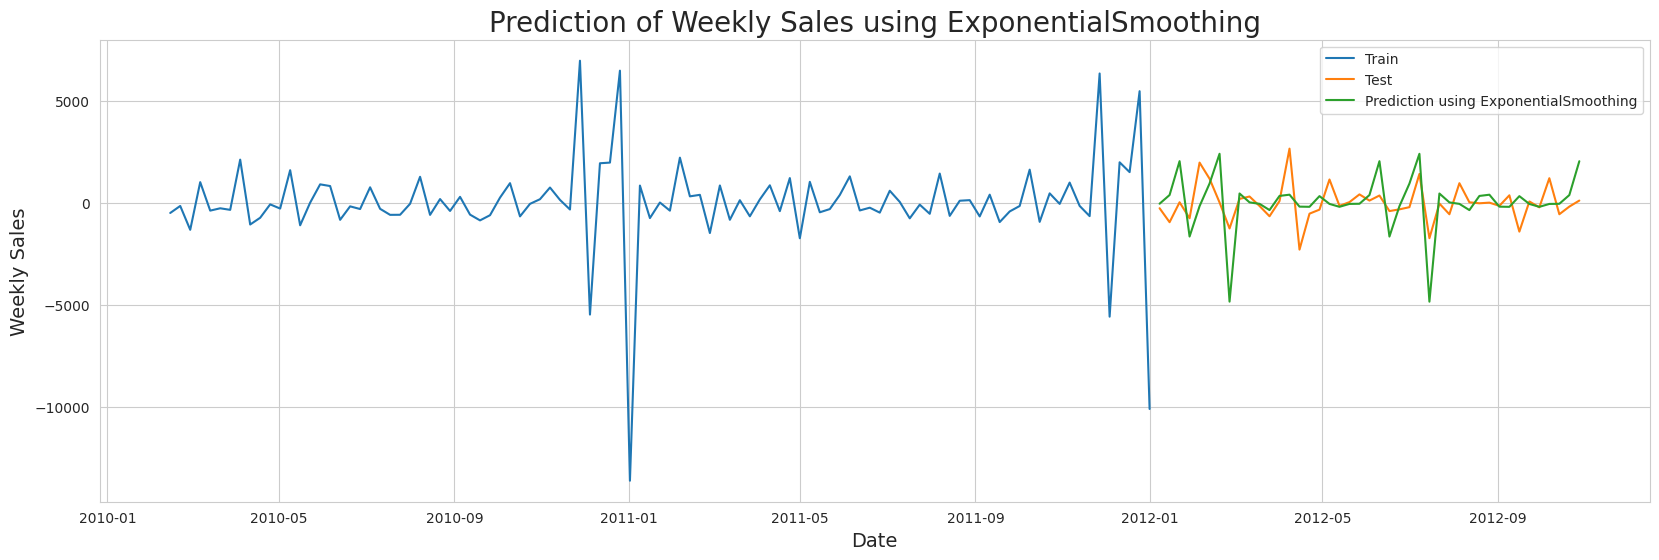

In [ ]:
#Fitting the Holt-Winters model with additive trend and seasonality, and damped trend
model_holt_winters = ExponentialSmoothing(train_data_diff, seasonal_periods=20, seasonal='additive',
                                           trend='additive', damped=True).fit()

#Forecasting the next period based on the model fitted
y_pred = model_holt_winters.forecast(len(test_data_diff))  # Prevendo os dados de teste

# Visualizing the train, test, and predicted data
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales using ExponentialSmoothing', fontsize=20)
plt.plot(train_data_diff, label='Train')
plt.plot(test_data_diff, label='Test')
plt.plot(y_pred, label='Prediction using ExponentialSmoothing')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()

In [ ]:
#Calculate WMAE for the test data and predictions
wmae_test(test_data_diff, y_pred)

np.float64(841.4381099968898)

I used Exponential Smoothing, which in the end gave me a WMAE of 841, remembering that before applying the model, the WMAE was 2713, indicating that exponential smoothing was effective in capturing the trends and seasonal patterns in the data, resulting in much more accurate forecasts. This improvement suggests that the model was able to better adjust for fluctuations and variations, providing a more reliable prediction
